In [1]:
import math
import xarray as xr
import cartopy.crs as crs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
from matplotlib.pyplot import figure
import numpy as np
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import pyproj
import utm
import pandas as pd 
import traceback 
from pathlib import Path  
import os  
import numpy.ma as ma
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import datetime as dt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
from netCDF4 import date2num,num2date
import wrf
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords
from wrf import getvar, xy, interp2dxy
from wrf import to_np, getvar, CoordPair, vertcross
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)

In [2]:
#CURRENT DATA
cur_wrfout6 = Dataset('CUR_wrfout_d03_2018-03-25_06_00_00')
cur_wrfout10 = Dataset('CUR_wrfout_d03_2018-03-25_10_00_00')
cur_wrfout11= Dataset('CUR_wrfout_d03_2018-03-25_11_00_00')
cur_wrfout12 = Dataset('CUR_wrfout_d03_2018-03-25_12_00_00')
cur_wrfout13= Dataset('CUR_wrfout_d03_2018-03-25_13_00_00')


In [3]:
#SST DATA
sst_wrfout6 = Dataset('SST_wrfout_d03_2018-03-25_06_00_00')
sst_wrfout10 = Dataset('SST_wrfout_d03_2018-03-25_10_00_00')
sst_wrfout11 = Dataset('SST_wrfout_d03_2018-03-25_11_00_00')
sst_wrfout12 = Dataset('SST_wrfout_d03_2018-03-25_12_00_00')
sst_wrfout13 = Dataset('SST_wrfout_d03_2018-03-25_13_00_00')


In [4]:
#Open HYCOM 25
ds_25 = xr.open_mfdataset('/Users/Anna/Desktop/MSMET/Thesis/WRFprepData/March2018HYCOM/020_archv.2018_084_*_3z.nc')#, combine = 'by_coords', concat_dim = 'time')
ds_25.to_netcdf('test_25.nc')
ds25 = xr.open_dataset('test_25.nc')

#WRFIN_D03
wrfinput_d03 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/wrfinput_d03')

In [5]:
old_d03_SST = wrfinput_d03.SST.values-273.15
old_d03_UOCE = wrfinput_d03.UOCE.values
old_d03_VOCE = wrfinput_d03.VOCE.values
XLAT = wrfinput_d03.XLAT.values
XLON = wrfinput_d03.XLONG.values

print('XLAT: ', XLAT.shape, '\nXLON: ', XLON.shape )
print('Max lat: ', np.max(XLAT), '\Min lat: ', np.min(XLAT))
print('Max lon: ', np.max(XLON), '\Min lon: ', np.min(XLON))
print ('d03_UOCE: ',old_d03_UOCE.shape, '\nd03_VOCE: ',  old_d03_VOCE.shape, '\nd03_SST: ', old_d03_SST.shape)

print('\n\n LAT: ', XLAT)
print('\n\n LON: ', XLON)

#REAL RUN 
latbounds = [24, 29]
lonbounds = [-95, -87]

lats = ds25.Latitude.values[:]
lons = ds25.Longitude.values[:]

#set upper & lower bounds
latli = np.argmin(np.abs(lats-latbounds[0]))
latui = np.argmin(np.abs(lats-latbounds[1]))
lonli = np.argmin(np.abs(lons-lonbounds[0]))
lonui = np.argmin(np.abs(lons-lonbounds[1]))

lat_array=ds25.Latitude.values[latli:latui]
lon_array=ds25.Longitude.values[lonli:lonui]
u_subset_25=ds25.variables['u'][:,0,latli:latui, lonli:lonui]
meanU_25 = u_subset_25.mean('MT')
#meanU_25=meanU_25*0.54 - 0.19
meanU_25=meanU_25*0.75-0.15

#v current
v_subset_25=ds25.variables['v'][:,0,latli:latui, lonli:lonui]
meanV_25 = v_subset_25.mean('MT')
meanV_25=meanV_25*0.27+0.78
#meanV_25=meanV_25

#SST
SST_subset_25=ds25.variables['water_temp'][:,0,latli:latui, lonli:lonui]
meanSST_25 = SST_subset_25.mean('MT')

XLAT:  (1, 474, 639) 
XLON:  (1, 474, 639)
Max lat:  28.640232 \Min lat:  24.351265
Max lon:  -86.96835 \Min lon:  -93.500946
d03_UOCE:  (1, 474, 639) 
d03_VOCE:  (1, 474, 639) 
d03_SST:  (1, 474, 639)


 LAT:  [[[24.351944 24.352158 24.352379 ... 24.351715 24.351501 24.351265]
  [24.360924 24.361137 24.361351 ... 24.360687 24.360466 24.360252]
  [24.369919 24.370125 24.370338 ... 24.369705 24.369476 24.369255]
  ...
  [28.586124 28.586365 28.58659  ... 28.585907 28.585674 28.58545 ]
  [28.595127 28.59534  28.59557  ... 28.594894 28.594662 28.594429]
  [28.604115 28.604328 28.604568 ... 28.603882 28.603653 28.60342 ]]]


 LON:  [[[-93.38281  -93.372955 -93.3631   ... -87.10733  -87.09747  -87.087585]
  [-93.38306  -93.37317  -93.36334  ... -87.107086 -87.09723  -87.08734 ]
  [-93.3833   -93.37341  -93.363556 ... -87.10684  -87.096985 -87.08713 ]
  ...
  [-93.50043  -93.490204 -93.47995  ... -86.98935  -86.979126 -86.96887 ]
  [-93.50067  -93.49045  -93.480225 ... -86.989075 -86.97885  

In [6]:
#March 25 Dopplerscat
ds25_5 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0326-0368_line05.L2.nc')
ds25_6 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0380-0436_line06.L2.nc')
ds25_7 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0450-0490_line07.L2.nc')


In [7]:
#set other DS variables 
lat25_5=ds25_5.latitude.values
lon25_5=ds25_5.longitude.values
flag25_5=ds25_5.flag.values
u_cur25_5=ds25_5.u_current.values

lat25_6=ds25_6.latitude.values
lon25_6=ds25_6.longitude.values
flag25_6=ds25_6.flag.values
u_cur25_6=ds25_6.u_current.values

lat25_7=ds25_7.latitude.values
lon25_7=ds25_7.longitude.values
flag25_7=ds25_7.flag.values
u_cur25_7=ds25_7.u_current.values

#v current
v_cur25_5=ds25_5.v_current.values
v_cur25_6=ds25_6.v_current.values
v_cur25_7=ds25_7.v_current.values


In [8]:
#Apply Error Flag 
#0 is good, 2 is bad
#set flag to only accept 0
   
lonlen25_5=len(lon25_5)
latlen25_5=len(lat25_5)

goodUarr25_5=np.zeros((latlen25_5,lonlen25_5))
goodUarr25_5[:]=np.nan
goodVarr25_5=np.zeros((latlen25_5,lonlen25_5))
goodVarr25_5[:]=np.nan
for x in range (len(lon25_5)):
    for y in range (len(lat25_5)):
        if flag25_5[y,x] == 0:
            goodUarr25_5[y,x] = u_cur25_5[y,x] 
            goodVarr25_5[y,x] = v_cur25_5[y,x] 
            
lonlen25_6=len(lon25_6)
latlen25_6=len(lat25_6)
goodUarr25_6=np.zeros((latlen25_6,lonlen25_6))
goodUarr25_6[:]=np.nan
goodVarr25_6=np.zeros((latlen25_6,lonlen25_6))
goodVarr25_6[:]=np.nan
for x in range (len(lon25_6)):
    for y in range (len(lat25_6)):
        if flag25_6[y,x] == 0:
            goodUarr25_6[y,x] = u_cur25_6[y,x] 
            goodVarr25_6[y,x] = v_cur25_6[y,x] 
            
lonlen25_7=len(lon25_7)
latlen25_7=len(lat25_7)
goodUarr25_7=np.zeros((latlen25_7,lonlen25_7))
goodUarr25_7[:]=np.nan
goodVarr25_7=np.zeros((latlen25_7,lonlen25_7))
goodVarr25_7[:]=np.nan
for x in range (len(lon25_7)):
    for y in range (len(lat25_7)):
        if flag25_7[y,x] == 0:
            goodUarr25_7[y,x] = u_cur25_7[y,x] 
            goodVarr25_7[y,x] = v_cur25_7[y,x] 


In [9]:
#Gaussian Filter U25
HYCOM_lat = lat_array
HYCOM_lon = lon_array

#REAL RUN 1 
WRF_lat = XLAT[0,:,0]
WRF_lon = XLON[0,0,:]
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)


#make current arrays (u & v) that match lat & lon dimensions, fill with nans 
u25_WRF  = np.zeros((WRF_latLen, WRF_lonLen))   
u25_WRF[:] = -999
DS_weightedU25 = u25_WRF*0
HYCOM_weightedU25 = u25_WRF*0

#at equator, 1deg = 111.31949077920639km, so 1km*(1deg/111.31949077920639km) = 0.00898315
#Great Circle Calculator 
#http://edwilliams.org/gccalc.htm

km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 #degrees  0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 1.0 #0.5-1.0 #km 
#sigma_DS_km = sigma_DS*km_per_deg
sigma_DS_km = sigma_DS

for y in range (0, WRF_latLen):  
#for y in range (0, len(WRF_lat)):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
    #for x in range (0, len(WRF_lon)):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_u25HYCOM = 0

        sum_weight_DS25u5 = 0
        sum_product_u25DS5 = 0
        sum_weight_DS25u6 = 0
        sum_product_u25DS6 = 0
        sum_weight_DS25u7 = 0
        sum_product_u25DS7 = 0
       
        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])  

        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #DS lat/lon comparison

        DS25u5_test1_In = np.where(lon25_5 >= min_lon)
        DS25u5_test2_In = np.where(lon25_5 <= max_lon)
        DS25u5_inter_like_lon = np.intersect1d(DS25u5_test1_In, DS25u5_test2_In)
        DS25u5_test1_In = np.where(lat25_5 >= min_lat)
        DS25u5_test2_In = np.where(lat25_5 <= max_lat)
        DS25u5_inter_like_lat = np.intersect1d(DS25u5_test1_In, DS25u5_test2_In) 
        
        DS25u6_test1_In = np.where(lon25_6 >= min_lon)
        DS25u6_test2_In = np.where(lon25_6 <= max_lon)
        DS25u6_inter_like_lon = np.intersect1d(DS25u6_test1_In, DS25u6_test2_In)
        DS25u6_test1_In = np.where(lat25_6 >= min_lat)
        DS25u6_test2_In = np.where(lat25_6 <= max_lat)
        DS25u6_inter_like_lat = np.intersect1d(DS25u6_test1_In, DS25u6_test2_In) 

        DS25u7_test1_In = np.where(lon25_7 >= min_lon)
        DS25u7_test2_In = np.where(lon25_7 <= max_lon)
        DS25u7_inter_like_lon = np.intersect1d(DS25u7_test1_In, DS25u7_test2_In)
        DS25u7_test1_In = np.where(lat25_7 >= min_lat)
        DS25u7_test2_In = np.where(lat25_7 <= max_lat)
        DS25u7_inter_like_lat = np.intersect1d(DS25u7_test1_In, DS25u7_test2_In)

        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #DS index     
        DS25u5_lon_indices =  DS25u5_inter_like_lon
        DS25u5_lat_indices =  DS25u5_inter_like_lat
        DS25u6_lon_indices =  DS25u6_inter_like_lon
        DS25u6_lat_indices =  DS25u6_inter_like_lat
        DS25u7_lon_indices =  DS25u7_inter_like_lon
        DS25u7_lat_indices =  DS25u7_inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
        
        #Good DS index
        DS25u5_good_lon = lon25_5[DS25u5_lon_indices]
        DS25u5_good_lat = lat25_5[DS25u5_lat_indices] 
        DS25u6_good_lon = lon25_6[DS25u6_lon_indices]
        DS25u6_good_lat = lat25_6[DS25u6_lat_indices] 
        DS25u7_good_lon = lon25_7[DS25u7_lon_indices]
        DS25u7_good_lat = lat25_7[DS25u7_lat_indices] 
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
        
        #DS length of food arrays 
        DS25u5_good_lon_len = len(DS25u5_good_lon)
        DS25u5_good_lat_len = len(DS25u5_good_lat) 
        DS25u6_good_lon_len = len(DS25u6_good_lon)
        DS25u6_good_lat_len = len(DS25u6_good_lat)  
        DS25u7_good_lon_len = len(DS25u7_good_lon)
        DS25u7_good_lat_len = len(DS25u7_good_lat)      
        
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                #if distance <= 3 * sigma_HYCOM: 
                    #weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    weight_HYCOM = 800*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    #weight_HYCOM = 0.2*(1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM

                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_u25HYCOM = sum_product_u25HYCOM + weight_HYCOM * meanU_25[lat_indices[y_small], lon_indices[x_small]]
                #print('sum product HYCOM', sum_product_u25HYCOM)
                HYCOM_weightedU25[y,x] =  (sum_product_u25HYCOM/sum_weight_HYCOM)
        #print('sum product HYCOM', sum_product_u25HYCOM)
        #loop through values of good DS arrays 
         
        for y_small_DS25u5 in range(0, DS25u5_good_lat_len):
            for x_small_DS25u5 in range(0, DS25u5_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25u5_good_lat[y_small_DS25u5]-WRF_lat[y])**2+((DS25u5_good_lon[x_small_DS25u5]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_5[DS25u5_lat_indices[y_small_DS25u5], DS25u5_lon_indices[x_small_DS25u5]]): 
                    weight_DS25u5 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u5 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u5 = sum_weight_DS25u5 + weight_DS25u5
                    sum_product_u25DS5 = sum_product_u25DS5 + weight_DS25u5 * goodUarr25_5[DS25u5_lat_indices[y_small_DS25u5], DS25u5_lon_indices[x_small_DS25u5]]
                    #print('sum_product_u25DS5: ', sum_product_u25DS5)
                else: 
                    weight_DS25u5 = 0 
                    
        for y_small_DS25u6 in range(0, DS25u6_good_lat_len):
            for x_small_DS25u6 in range(0, DS25u6_good_lon_len):          
                distance=(km_per_deg)*np.sqrt((DS25u6_good_lat[y_small_DS25u6]-WRF_lat[y])**2+((DS25u6_good_lon[x_small_DS25u6]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_6[DS25u6_lat_indices[y_small_DS25u6], DS25u6_lon_indices[x_small_DS25u6]]): 
                    weight_DS25u6 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u6 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u6 = sum_weight_DS25u6 + weight_DS25u6
                    sum_product_u25DS6 = sum_product_u25DS6 + weight_DS25u6 * goodUarr25_6[DS25u6_lat_indices[y_small_DS25u6], DS25u6_lon_indices[x_small_DS25u6]]
                else: 
                    weight_DS25u6 = 0 
                    
        for y_small_DS25u7 in range(0, DS25u7_good_lat_len):
            for x_small_DS25u7 in range(0, DS25u7_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25u7_good_lat[y_small_DS25u7]-WRF_lat[y])**2+((DS25u7_good_lon[x_small_DS25u7]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_7[DS25u7_lat_indices[y_small_DS25u7], DS25u7_lon_indices[x_small_DS25u7]]): 
                    weight_DS25u7 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u7 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u7 = sum_weight_DS25u7 + weight_DS25u7
                    sum_product_u25DS7 = sum_product_u25DS7 + weight_DS25u7 * goodUarr25_7[DS25u7_lat_indices[y_small_DS25u7], DS25u7_lon_indices[x_small_DS25u7]]
                else: 
                    weight_DS25u7 = 0 
        #print('sum_product_DS: ', sum_product_u25DS5+sum_product_u25DS6+ sum_product_u25DS7)
            
    #outside of loop: sum of products/sum of weights
        DS_weight = (sum_weight_DS25u5 + sum_weight_DS25u6 + sum_weight_DS25u7) #add each DS sum, add ech sum weigth     
        if DS_weight != 0: 
            DS_weightedU25[y,x] =  (sum_product_u25DS5 + sum_product_u25DS6 + sum_product_u25DS7)/ DS_weight 
        else: 
            DS_weightedU25[y,x] = -999
            
        u25_WRF[y,x] = (sum_product_u25HYCOM + sum_product_u25DS5 + sum_product_u25DS6 + sum_product_u25DS7)/(sum_weight_HYCOM + sum_weight_DS25u5 + sum_weight_DS25u6 + sum_weight_DS25u7) #add each DS sum, add ech sum weigth 


In [10]:
print(u25_WRF.shape) #<---- this the the UOCE for WRF 
print(WRF_lon.shape)
print(WRF_lat.shape)
print(u25_WRF)
print(DS_weightedU25.shape)
print(HYCOM_weightedU25.shape)

for x in u25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in u25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')

(474, 639)
(639,)
(474,)
[[-0.03676818 -0.03676818 -0.03462522 ... -0.39933854 -0.39933854
  -0.39933854]
 [-0.03676818 -0.03574877 -0.03462471 ... -0.40015855 -0.39933854
  -0.39933854]
 [-0.03759319 -0.0365577  -0.03541112 ... -0.39922357 -0.39837169
  -0.39933854]
 ...
 [-0.05680274 -0.05675372 -0.05664098 ... -0.01681774 -0.01658411
  -0.01658411]
 [-0.05700583 -0.05694038 -0.05687633 ... -0.01609657 -0.01579646
  -0.01508605]
 [-0.057189   -0.05710773 -0.05702867 ... -0.01545005 -0.01508605
  -0.01508605]]
(474, 639)
(474, 639)


In [11]:
#Gaussian Filter V25
#HYCOM: lat_array (Y), lon_array (X), meanU_25
#DS: goodUarr25_1-10, lat25_1, lon25_1s

HYCOM_lat = lat_array
HYCOM_lon = lon_array

#REAL RUN 1 
WRF_lat = XLAT[0,:,0]
WRF_lon = XLON[0,0,:]
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)

v25_WRF = np.zeros((WRF_latLen, WRF_lonLen))  
#u25_WRF[:] = -999
v25_WRF[:] = -999

DS_weightedV25 = v25_WRF*0
HYCOM_weightedV25= v25_WRF*0

#DS sigma??? = 0.03 # 0.015*2   
km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 #degrees  0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 1.0 #0.5-1.0 #km 
#sigma_DS_km = sigma_DS*km_per_deg
sigma_DS_km = sigma_DS


for y in range (0, WRF_latLen):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_v25HYCOM = 0

        sum_weight_DS25v5 = 0
        sum_product_v25DS5 = 0
        sum_weight_DS25v6 = 0
        sum_product_v25DS6 = 0
        sum_weight_DS25v7 = 0
        sum_product_v25DS7 = 0

        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])   
        
        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #DS lat/lon comparison

        DS25v5_test1_In = np.where(lon25_5 >= min_lon)
        DS25v5_test2_In = np.where(lon25_5 <= max_lon)
        DS25v5_inter_like_lon = np.intersect1d(DS25v5_test1_In, DS25v5_test2_In)
        DS25v5_test1_In = np.where(lat25_5 >= min_lat)
        DS25v5_test2_In = np.where(lat25_5 <= max_lat)
        DS25v5_inter_like_lat = np.intersect1d(DS25v5_test1_In, DS25v5_test2_In) 
        
        DS25v6_test1_In = np.where(lon25_6 >= min_lon)
        DS25v6_test2_In = np.where(lon25_6 <= max_lon)
        DS25v6_inter_like_lon = np.intersect1d(DS25v6_test1_In, DS25v6_test2_In)
        DS25v6_test1_In = np.where(lat25_6 >= min_lat)
        DS25v6_test2_In = np.where(lat25_6 <= max_lat)
        DS25v6_inter_like_lat = np.intersect1d(DS25v6_test1_In, DS25v6_test2_In) 

        DS25v7_test1_In = np.where(lon25_7 >= min_lon)
        DS25v7_test2_In = np.where(lon25_7 <= max_lon)
        DS25v7_inter_like_lon = np.intersect1d(DS25v7_test1_In, DS25v7_test2_In)
        DS25v7_test1_In = np.where(lat25_7 >= min_lat)
        DS25v7_test2_In = np.where(lat25_7 <= max_lat)
        DS25v7_inter_like_lat = np.intersect1d(DS25v7_test1_In, DS25v7_test2_In)

        #np.where((HYCOM_lon >= min_lon) and (HYCOM_lon <= max_lon), HYCOM_lon)
        #np.where((HYCOM_lat >= min_lat) and (HYCOM_lat <= max_lat))
        
        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #DS index       
        DS25v5_lon_indices =  DS25v5_inter_like_lon
        DS25v5_lat_indices =  DS25v5_inter_like_lat
        DS25v6_lon_indices =  DS25v6_inter_like_lon
        DS25v6_lat_indices =  DS25v6_inter_like_lat
        DS25v7_lon_indices =  DS25v7_inter_like_lon
        DS25v7_lat_indices =  DS25v7_inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
        
        #Good DS index
        DS25v5_good_lon = lon25_5[DS25v5_lon_indices]
        DS25v5_good_lat = lat25_5[DS25v5_lat_indices] 
        DS25v6_good_lon = lon25_6[DS25v6_lon_indices]
        DS25v6_good_lat = lat25_6[DS25v6_lat_indices] 
        DS25v7_good_lon = lon25_7[DS25v7_lon_indices]
        DS25v7_good_lat = lat25_7[DS25v7_lat_indices] 
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
        
        #DS length of food arrays 
        DS25v5_good_lon_len = len(DS25v5_good_lon)
        DS25v5_good_lat_len = len(DS25v5_good_lat) 
        DS25v6_good_lon_len = len(DS25v6_good_lon)
        DS25v6_good_lat_len = len(DS25v6_good_lat)  
        DS25v7_good_lon_len = len(DS25v7_good_lon)
        DS25v7_good_lat_len = len(DS25v7_good_lat)     
        
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                #print('distance: ', distance)
                #print('3sigma', 3*sigma_HYCOM)
                #print(y, x, y_small, x_small, distance, good_lat[y_small], WRF_lat[y], good_lon[x_small], WRF_lon[x])
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                    #weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    weight_HYCOM = 800*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM
                #print('sum_weight_HYCOM: ', sum_weight_HYCOM)

                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_v25HYCOM = sum_product_v25HYCOM + weight_HYCOM * meanV_25[lat_indices[y_small], lon_indices[x_small]]
                HYCOM_weightedV25[y,x] =  sum_product_v25HYCOM/sum_weight_HYCOM

        for y_small_DS25v5 in range(0, DS25v5_good_lat_len):
            for x_small_DS25v5 in range(0, DS25v5_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25v5_good_lat[y_small_DS25v5]-WRF_lat[y])**2+((DS25v5_good_lon[x_small_DS25v5]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_5[DS25v5_lat_indices[y_small_DS25v5], DS25v5_lon_indices[x_small_DS25v5]]): 
                    weight_DS25v5 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v5 = sum_weight_DS25v5 + weight_DS25v5
                    sum_product_v25DS5 = sum_product_v25DS5 + weight_DS25v5 * goodVarr25_5[DS25v5_lat_indices[y_small_DS25v5], DS25v5_lon_indices[x_small_DS25v5]]
                else: 
                    weight_DS25v5 = 0 
                    
        for y_small_DS25v6 in range(0, DS25v6_good_lat_len):
            for x_small_DS25v6 in range(0, DS25v6_good_lon_len):          
                distance=(km_per_deg)*np.sqrt((DS25v6_good_lat[y_small_DS25v6]-WRF_lat[y])**2+((DS25v6_good_lon[x_small_DS25v6]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_6[DS25v6_lat_indices[y_small_DS25v6], DS25v6_lon_indices[x_small_DS25v6]]): 
                    weight_DS25v6 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v6 = sum_weight_DS25v6 + weight_DS25v6
                    sum_product_v25DS6 = sum_product_v25DS6 + weight_DS25v6 * goodVarr25_6[DS25v6_lat_indices[y_small_DS25v6], DS25v6_lon_indices[x_small_DS25v6]]
                else: 
                    weight_DS25v6 = 0 
                    
        for y_small_DS25v7 in range(0, DS25v7_good_lat_len):
            for x_small_DS25v7 in range(0, DS25v7_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25v7_good_lat[y_small_DS25v7]-WRF_lat[y])**2+((DS25v7_good_lon[x_small_DS25v7]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_7[DS25v7_lat_indices[y_small_DS25v7], DS25v7_lon_indices[x_small_DS25v7]]): 
                    weight_DS25v7 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v7 = sum_weight_DS25v7 + weight_DS25v7
                    sum_product_v25DS7 = sum_product_v25DS7 + weight_DS25v7 * goodVarr25_7[DS25v7_lat_indices[y_small_DS25v7], DS25v7_lon_indices[x_small_DS25v7]]
                else: 
                    weight_DS25v7 = 0 
           
    #outside of loop: sum of products/sum of weights
        DS_weight = (sum_weight_DS25v5 + sum_weight_DS25v6 + sum_weight_DS25v7) #add each DS sum, add ech sum weigth     
        if DS_weight != 0: 
            DS_weightedV25[y,x] =  (sum_product_v25DS5 + sum_product_v25DS6 + sum_product_v25DS7)/(DS_weight) #add each DS sum, add ech sum weigth 
        else: 
            DS_weightedV25[y,x] = -999
                     
        v25_WRF[y,x] = (sum_product_v25HYCOM + sum_product_v25DS5 + sum_product_v25DS6 + sum_product_v25DS7)/(sum_weight_HYCOM + sum_weight_DS25v5 + sum_weight_DS25v6 + sum_weight_DS25v7) #add each DS sum, add ech sum weigth 


In [12]:
print(v25_WRF.shape)
print(WRF_lon.shape)
print(WRF_lat.shape)
print(v25_WRF)
print(DS_weightedV25.shape)
print(HYCOM_weightedV25.shape)

for x in v25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in v25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')  
print('sigma DS:', sigma_DS)
print('sigma HYCOM', sigma_HYCOM)

(474, 639)
(639,)
(474,)
[[0.86421758 0.86421758 0.86442354 ... 0.94721484 0.94721484 0.94721484]
 [0.86421758 0.86431556 0.86442359 ... 0.94785106 0.94721484 0.94721484]
 [0.86413716 0.86423675 0.86434702 ... 0.94774068 0.94711906 0.94721484]
 ...
 [0.80682278 0.80683526 0.80685814 ... 0.86809943 0.86792558 0.86792558]
 [0.80677201 0.80678861 0.80680485 ... 0.86801113 0.86782245 0.86772943]
 [0.80672622 0.80674678 0.80676678 ... 0.86793198 0.86772943 0.86772943]]
(474, 639)
(474, 639)
sigma DS: 1.0
sigma HYCOM 0.02


In [13]:
#Vorticity ----> WRF currents vorticity
Y = WRF_lat #474
X = WRF_lon #613
U =  u25_WRF #474, 613
V =  v25_WRF #474, 613
print('X: ', X.shape)
print('Y: ', Y.shape)
print('U: ', U.shape)
print('V: ', V.shape)

#metpy vort
#Vorticity=curl
dxdy=mpcalc.lat_lon_grid_deltas(longitude=WRF_lon, latitude=WRF_lat, x_dim=- 1, y_dim=- 2, geod=None)
#print(dxdy.shape)
#print(dxdy)

#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
mp_curl=mpcalc.vorticity(u=u25_WRF*units('m/s'), v=v25_WRF*units('m/s'), dx=dxdy[0], dy=dxdy[1])


X:  (639,)
Y:  (474,)
U:  (474, 639)
V:  (474, 639)


C:\Users\Anna\anaconda3\envs\metpy\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


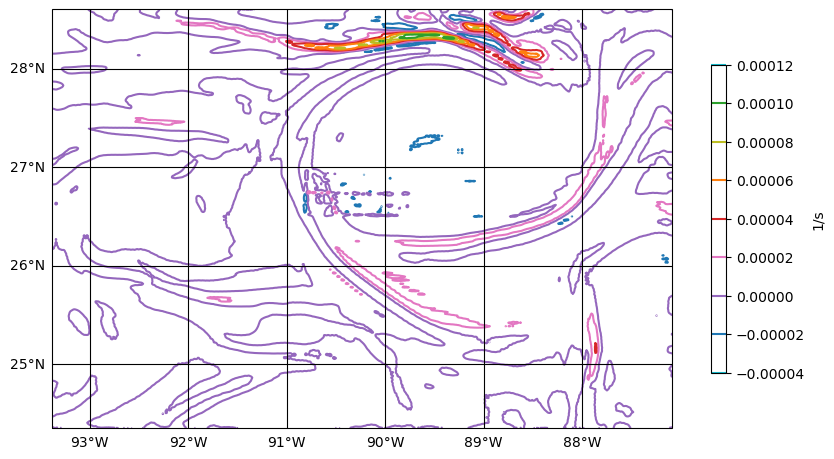

In [14]:
#metpy curl plot 
Y = WRF_lat
X = WRF_lon
U =  u25_WRF
V =  v25_WRF

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]

lon2D, lat2D = np.meshgrid(X, Y)
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#ax.set_extent([-90.9, -89.65, 26.45, 27.15], crs=mapcrs)
ax.coastlines()

cs = ax.contour(X, Y, mp_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
skip = (slice(None, None, 20), slice(None, None, 20))
plt.quiver(lon2D[skip], lat2D[skip], U[skip], V[skip], color = 'white') #lon, lat, u_curent, v_current
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False

plt.show()


In [15]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)

#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [16]:

S_U= []
for y in lat_int_south:
    inner_arr = []
    for x in lon_int_south:
        inner_arr.append(U[y][x])
    S_U.append(inner_arr)
S_U = np.array(S_U)
print('S_U shape: ', S_U.shape)

N_U= []
for y in lat_int_north:
    inner_arr2 = []
    for x in lon_int_north:
        inner_arr2.append(U[y][x])
    N_U.append(inner_arr2)
N_U = np.array(N_U) 
print('N_U shape: ', N_U.shape)

S_V= []
for y in lat_int_south:
    inner_arr3 = []
    for x in lon_int_south:
        inner_arr3.append(V[y][x])
    S_V.append(inner_arr3)
S_V = np.array(S_V)
print('S_V shape: ', S_V.shape)

N_V= []
for y in lat_int_north:
    inner_arr4 = []
    for x in lon_int_north:
        inner_arr4.append(V[y][x])
    N_V.append(inner_arr4)
N_V = np.array(N_V) 
print('N_V shape: ', N_V.shape)

S_U shape:  (67, 118)
N_U shape:  (67, 167)
S_V shape:  (67, 118)
N_V shape:  (67, 167)


In [17]:
X= np.array(north_lon)
Y= np.array(north_lat)
#U=N_U
#V=N_V

dxdy=mpcalc.lat_lon_grid_deltas(longitude=X, latitude=Y, x_dim=- 1, y_dim=- 2, geod=None)
 
N_curl=mpcalc.vorticity(u=N_U*units('m/s'), v=N_V*units('m/s'), dx=dxdy[0], dy=dxdy[1])
print(N_curl)

[[6.0438661694226e-06 5.4839157263247395e-06 4.337422843672141e-06 ...  -1.3130351088453426e-05 -1.339964972999028e-05 -1.1906327183874941e-05] [8.456424770323043e-06 8.386938342410362e-06 7.083131685377229e-06 ...  -1.3836817165353485e-05 -1.3349044470078346e-05 -1.2682185872483988e-05] [1.0725978828764857e-05 1.0638568722113202e-05 9.40148647724148e-06 ...  -1.4380345837226188e-05 -1.3526257418534492e-05 -1.2272570620031336e-05] ... [-1.5623052149268982e-05 -1.58956604641503e-05 -1.662372085340354e-05  ... 4.666813239488875e-05 4.670134823793503e-05 4.738935294405608e-05] [-1.5946385329362954e-05 -1.6182185528596394e-05 -1.675986950177598e-05  ... 3.720178226394931e-05 3.661441746119483e-05 3.660824482204263e-05] [-1.4277565148521364e-05 -1.6195794264660352e-05 -1.6150997518188154e-05  ... 2.9776675463971615e-05 3.0107353235049204e-05 2.354627547865876e-05]] / second


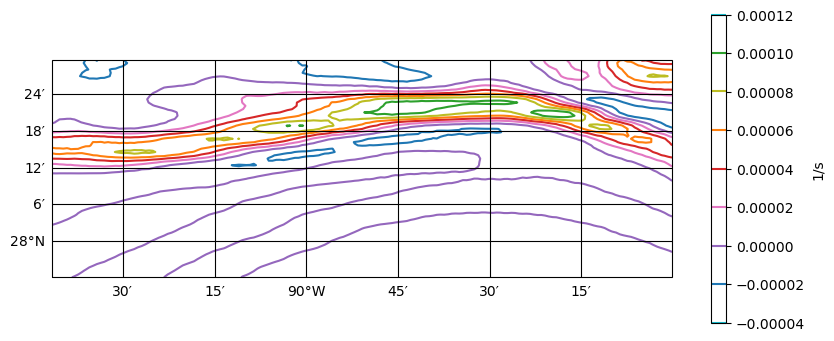

In [18]:

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False

plt.show()

In [19]:
X2= np.array(south_lon)
Y2= np.array(south_lat)
#U2=N_U
#V2=N_V

dxdy=mpcalc.lat_lon_grid_deltas(longitude=X2, latitude=Y2, x_dim=- 1, y_dim=- 2, geod=None)
 
S_curl=mpcalc.vorticity(u=S_U*units('m/s'), v=S_V*units('m/s'), dx=dxdy[0], dy=dxdy[1])
print(S_curl)

[[-1.1356667272870751e-05 -1.1242816221363723e-05 -6.928646623509341e-06  ... 9.427031521394439e-06 9.069987097998775e-06 8.754240009654435e-06] [-8.992385778808758e-06 -5.4688753835724965e-06 -6.138354801861083e-07  ... 8.87014676660675e-06 8.863800220135774e-06 8.504148854027193e-06] [-5.154055347921442e-06 -2.2010937545630473e-07 4.8039228708998455e-06  ... 9.034483209232713e-06 8.879974253863667e-06 8.875936729634112e-06] ... [-2.175676583582634e-05 -2.098573306808264e-05 -1.9732313492456827e-05  ... -1.3536393756093026e-05 -1.3200959035693845e-05  -1.3118424623483624e-05] [-2.0243701862002195e-05 -2.0022253933831935e-05 -1.918433741922369e-05  ... -1.2853959646554286e-05 -1.2722557453745495e-05  -1.2266396242174577e-05] [-1.596932362861838e-05 -1.8360756755333996e-05 -1.919440166976694e-05  ... -1.310219571807968e-05 -1.280638306683468e-05 -1.25642136893703e-05]] / second


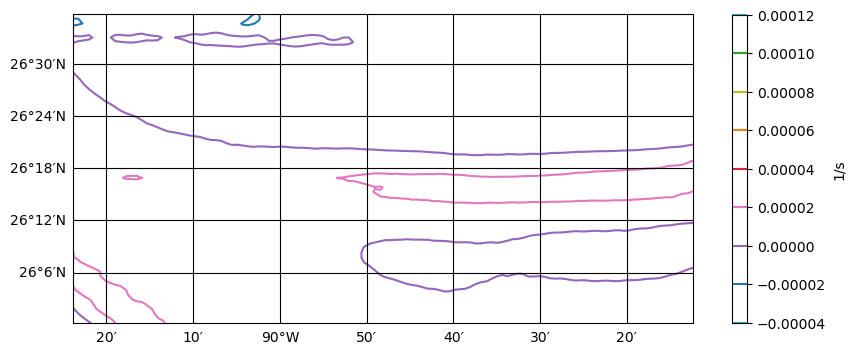

In [20]:
bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]

#lon2D, lat2D = np.meshgrid(X2, Y2)
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
skip = (slice(None, None, 20), slice(None, None, 20))
#plt.quiver(lon2D[skip], lat2D[skip], U[skip], V[skip], color = 'white') #lon, lat, u_curent, v_current
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False
#plt.title('Current Speed (Vector in m/s)\n& Curl (Contour in 1/s)')
#save_results_to = '/Users/Anna/Desktop/WRF/'
#plt.savefig(save_results_to + '25_Vectors.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [21]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)

#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [22]:
#Get PBLH
#Not staggered
cur_pblh_10 = getvar(cur_wrfout10, "PBLH")
cur_pblh_11 = getvar(cur_wrfout11, "PBLH")
cur_pblh_12 = getvar(cur_wrfout12, "PBLH")
cur_pblh_13 = getvar(cur_wrfout13, "PBLH")

sst_pblh_10 = getvar(sst_wrfout10, "PBLH")
sst_pblh_11 = getvar(sst_wrfout11, "PBLH")
sst_pblh_12 = getvar(sst_wrfout12, "PBLH")
sst_pblh_13 = getvar(sst_wrfout13, "PBLH")

#UST
sst_ustar_10 = getvar(sst_wrfout10, "UST")
sst_ustar_11 = getvar(sst_wrfout11, "UST")
sst_ustar_12 = getvar(sst_wrfout12, "UST")
sst_ustar_13 = getvar(sst_wrfout13, "UST")

cur_ustar_10 = getvar(cur_wrfout10, "UST")
cur_ustar_11 = getvar(cur_wrfout11, "UST")
cur_ustar_12 = getvar(cur_wrfout12, "UST")
cur_ustar_13 = getvar(cur_wrfout13, "UST")

roh = 1.225
#LHF - LH
sst_lhf_10 = getvar(sst_wrfout10, "LH")
sst_lhf_11 = getvar(sst_wrfout11, "LH")
sst_lhf_12 = getvar(sst_wrfout12, "LH")
sst_lhf_13 = getvar(sst_wrfout13, "LH")

cur_lhf_10 = getvar(cur_wrfout10, "LH")
cur_lhf_11 = getvar(cur_wrfout11, "LH")
cur_lhf_12 = getvar(cur_wrfout12, "LH")
cur_lhf_13 = getvar(cur_wrfout13, "LH")

#HFX  SHF 
sst_shf_10 = getvar(sst_wrfout10, "HFX")
sst_shf_11 = getvar(sst_wrfout11, "HFX")
sst_shf_12 = getvar(sst_wrfout12, "HFX")
sst_shf_13 = getvar(sst_wrfout13, "HFX")

cur_shf_10 = getvar(cur_wrfout10, "HFX")
cur_shf_11 = getvar(cur_wrfout11, "HFX")
cur_shf_12 = getvar(cur_wrfout12, "HFX")
cur_shf_13 = getvar(cur_wrfout13, "HFX")
'''
#Get U
cur_U_10 = getvar(cur_wrfout10, "U")
cur_U_11 = getvar(cur_wrfout11, "U")
cur_U_12 = getvar(cur_wrfout12, "U")
cur_U_13 = getvar(cur_wrfout13, "U")
cur_U_10 = wrf.destagger(cur_U_10, stagger_dim = 2)
cur_U_11  = wrf.destagger(cur_U_11, stagger_dim = 2)
cur_U_12 = wrf.destagger(cur_U_12, stagger_dim = 2)
cur_U_13  = wrf.destagger(cur_U_13, stagger_dim = 2)

cur_U10_10 = getvar(cur_wrfout10, "U10")
cur_U10_11 = getvar(cur_wrfout11, "U10")
cur_U10_12 = getvar(cur_wrfout12, "U10")
cur_U10_13 = getvar(cur_wrfout13, "U10")

sst_U_10 = getvar(sst_wrfout10, "U")
sst_U_11 = getvar(sst_wrfout11, "U")
sst_U_12 = getvar(sst_wrfout12, "U")
sst_U_13 = getvar(sst_wrfout13, "U")
sst_U_10 = wrf.destagger(sst_U_10, stagger_dim = 2)
sst_U_11  = wrf.destagger(sst_U_11, stagger_dim = 2)
sst_U_12 = wrf.destagger(sst_U_12, stagger_dim = 2)
sst_U_13  = wrf.destagger(sst_U_13, stagger_dim = 2)

sst_U10_10 = getvar(sst_wrfout10, "U10")
sst_U10_11 = getvar(sst_wrfout11, "U10")
sst_U10_12 = getvar(sst_wrfout12, "U10")
sst_U10_13 = getvar(sst_wrfout13, "U10")

cur_V_10 = getvar(cur_wrfout10, "V")
cur_V_11 = getvar(cur_wrfout11, "V")
cur_V_12 = getvar(cur_wrfout12, "V")
cur_V_13 = getvar(cur_wrfout13, "V")
cur_V_10 = wrf.destagger(cur_V_10, stagger_dim = 1)
cur_V_11  = wrf.destagger(cur_V_11, stagger_dim = 1)
cur_V_12 = wrf.destagger(cur_V_12, stagger_dim = 1)
cur_V_13  = wrf.destagger(cur_V_13, stagger_dim = 1)

cur_V10_10 = getvar(cur_wrfout10, "V10")
cur_V10_11 = getvar(cur_wrfout11, "V10")
cur_V10_12 = getvar(cur_wrfout12, "V10")
cur_V10_13 = getvar(cur_wrfout13, "V10")

sst_V_10 = getvar(sst_wrfout10, "V")
sst_V_11 = getvar(sst_wrfout11, "V")
sst_V_12 = getvar(sst_wrfout12, "V")
sst_V_13 = getvar(sst_wrfout13, "V")
sst_V_10 = wrf.destagger(sst_V_10, stagger_dim = 1)
sst_V_11  = wrf.destagger(sst_V_11, stagger_dim = 1)
sst_V_12 = wrf.destagger(sst_V_12, stagger_dim = 1)
sst_V_13  = wrf.destagger(sst_V_13, stagger_dim = 1)

sst_V10_10 = getvar(sst_wrfout10, "V10")
sst_V10_11 = getvar(sst_wrfout11, "V10")
sst_V10_12 = getvar(sst_wrfout12, "V10")
sst_V10_13 = getvar(sst_wrfout13, "V10")

'''

'\n#Get U\ncur_U_10 = getvar(cur_wrfout10, "U")\ncur_U_11 = getvar(cur_wrfout11, "U")\ncur_U_12 = getvar(cur_wrfout12, "U")\ncur_U_13 = getvar(cur_wrfout13, "U")\ncur_U_10 = wrf.destagger(cur_U_10, stagger_dim = 2)\ncur_U_11  = wrf.destagger(cur_U_11, stagger_dim = 2)\ncur_U_12 = wrf.destagger(cur_U_12, stagger_dim = 2)\ncur_U_13  = wrf.destagger(cur_U_13, stagger_dim = 2)\n\ncur_U10_10 = getvar(cur_wrfout10, "U10")\ncur_U10_11 = getvar(cur_wrfout11, "U10")\ncur_U10_12 = getvar(cur_wrfout12, "U10")\ncur_U10_13 = getvar(cur_wrfout13, "U10")\n\nsst_U_10 = getvar(sst_wrfout10, "U")\nsst_U_11 = getvar(sst_wrfout11, "U")\nsst_U_12 = getvar(sst_wrfout12, "U")\nsst_U_13 = getvar(sst_wrfout13, "U")\nsst_U_10 = wrf.destagger(sst_U_10, stagger_dim = 2)\nsst_U_11  = wrf.destagger(sst_U_11, stagger_dim = 2)\nsst_U_12 = wrf.destagger(sst_U_12, stagger_dim = 2)\nsst_U_13  = wrf.destagger(sst_U_13, stagger_dim = 2)\n\nsst_U10_10 = getvar(sst_wrfout10, "U10")\nsst_U10_11 = getvar(sst_wrfout11, "U10")\

In [7]:
'''
#AVG SFC VORT
cur_U10_N = np.mean( np.array([cur_U10_11, cur_U10_12, cur_U10_13]), axis=0 )
cur_V10_N = np.mean( np.array([cur_V10_11, cur_V10_12, cur_V10_13]), axis=0 )
sst_U10_N = np.mean( np.array([sst_U10_11, sst_U10_12, sst_U10_13]), axis=0 )
sst_V10_N = np.mean( np.array([sst_V10_11, sst_V10_12, sst_V10_13]), axis=0 )

cur_U10_S = np.mean( np.array([cur_U10_10, cur_U10_11, cur_U10_12]), axis=0 )
cur_V10_S = np.mean( np.array([cur_V10_10, cur_V10_11, cur_V10_12]), axis=0 )
sst_U10_S = np.mean( np.array([sst_U10_10, sst_U10_11, sst_U10_12]), axis=0 )
sst_V10_S = np.mean( np.array([sst_V10_10, sst_V10_11, sst_V10_12]), axis=0 )

#surface winds on subdomains
#CUR S U
south_cur_u10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U10_S[y][x])
    south_cur_u10.append(inner_arr_cur)
south_cur_u10 = np.array(south_cur_u10)
print('S', south_cur_u10.shape)

#CUR N U
north_cur_u10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U10_N[y][x])
    north_cur_u10.append(inner_arr_cur)
north_cur_u10 = np.array(north_cur_u10)
print('N', north_cur_u10.shape)

#SST S U
south_sst_u10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U10_S[y][x])
    south_sst_u10.append(inner_arr_sst)
south_sst_u10 = np.array(south_sst_u10)
print('S', south_sst_u10.shape)

#SST N U 
north_sst_u10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U10_N[y][x])
    north_sst_u10.append(inner_arr_sst)
north_sst_u10 = np.array(north_sst_u10)
print('N', north_sst_u10.shape)

#CUR S V
south_cur_v10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V10_S[y][x])
    south_cur_v10.append(inner_arr_cur)
south_cur_v10 = np.array(south_cur_v10)
print('S', south_cur_v10.shape)

#CUR N V
north_cur_v10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V10_N[y][x])
    north_cur_v10.append(inner_arr_cur)
north_cur_v10 = np.array(north_cur_v10)
print('N', north_cur_v10.shape)

#SST S V
south_sst_v10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V10_S[y][x])
    south_sst_v10.append(inner_arr_sst)
south_sst_v10 = np.array(south_sst_v10)
print('S', south_sst_v10.shape)

#SST N V 
north_sst_v10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V10_N[y][x])
    north_sst_v10.append(inner_arr_sst)
north_sst_v10 = np.array(north_sst_v10)
print('N', north_sst_v10.shape)

#surface winds vorticity
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)

sst_curl10_N = mpcalc.vorticity(u=north_sst_u10*units('m/s'), v=north_sst_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl10_S = mpcalc.vorticity(u=south_sst_u10*units('m/s'), v=south_sst_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl10_N = mpcalc.vorticity(u=north_cur_u10*units('m/s'), v=north_cur_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl10_S = mpcalc.vorticity(u=south_cur_u10*units('m/s'), v=south_cur_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

N_sfc_diff = cur_curl10_N - sst_curl10_N
S_sfc_diff = cur_curl10_S - sst_curl10_S
'''

S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)


In [8]:
'''
#AVG PBLH VORT 
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl13.shape)

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl13.shape)

#get on PBLH
print(sst_U_10.shape)
sst_uwind10_pblh = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10)
sst_uwind11_pblh = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11)
sst_uwind12_pblh = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12)
sst_uwind13_pblh = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13)

cur_uwind10_pblh = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10)
cur_uwind11_pblh = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11)
cur_uwind12_pblh = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12)
cur_uwind13_pblh = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13)

sst_vwind10_pblh = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10)
sst_vwind11_pblh = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11)
sst_vwind12_pblh = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12)
sst_vwind13_pblh = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13)

cur_vwind10_pblh = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10)
cur_vwind11_pblh = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11)
cur_vwind12_pblh = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12)
cur_vwind13_pblh = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13)
print(cur_vwind10_pblh.shape)

cur_U_N = np.mean( np.array([cur_uwind11_pblh, cur_uwind12_pblh, cur_uwind13_pblh]), axis=0 )
cur_V_N = np.mean( np.array([cur_vwind11_pblh, cur_vwind12_pblh, cur_vwind13_pblh]), axis=0 )
sst_U_N = np.mean( np.array([sst_uwind11_pblh, sst_uwind12_pblh, sst_uwind13_pblh]), axis=0 )
sst_V_N = np.mean( np.array([sst_vwind11_pblh, sst_vwind12_pblh, sst_vwind13_pblh]), axis=0 )

cur_U_S = np.mean( np.array([cur_uwind10_pblh, cur_uwind11_pblh, cur_uwind12_pblh]), axis=0 )
cur_V_S = np.mean( np.array([cur_vwind10_pblh, cur_vwind11_pblh, cur_vwind12_pblh]), axis=0 )
sst_U_S = np.mean( np.array([sst_uwind10_pblh, sst_uwind11_pblh, sst_uwind12_pblh]), axis=0 )
sst_V_S = np.mean( np.array([sst_vwind10_pblh, sst_vwind11_pblh, sst_vwind12_pblh]), axis=0 )
'''

(99, 474, 639)
(474, 639)


In [20]:
'''
#pblh winds on subdomains
#CUR S U
south_cur_u = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U_S[y][x])
    south_cur_u.append(inner_arr_cur)
south_cur_u = np.array(south_cur_u)
print(south_cur_u.shape)

#CUR N U
north_cur_u = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U_N[y][x])
    north_cur_u.append(inner_arr_cur)
north_cur_u = np.array(north_cur_u)

#SST S U
south_sst_u = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U_S[y][x])
    south_sst_u.append(inner_arr_sst)
south_sst_u = np.array(south_sst_u)

#SST N U 
north_sst_u = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U_N[y][x])
    north_sst_u.append(inner_arr_sst)
north_sst_u = np.array(north_sst_u)
print(north_sst_u.shape)

#CUR S V
south_cur_v = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V_S[y][x])
    south_cur_v.append(inner_arr_cur)
south_cur_v = np.array(south_cur_v)

#CUR N V
north_cur_v = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V_N[y][x])
    north_cur_v.append(inner_arr_cur)
north_cur_v = np.array(north_cur_v)

#SST S V
south_sst_v = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V_S[y][x])
    south_sst_v.append(inner_arr_sst)
south_sst_v = np.array(south_sst_v)

#SST N V 
north_sst_v = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V_N[y][x])
    north_sst_v.append(inner_arr_sst)
north_sst_v = np.array(north_sst_v)
print(north_sst_v.shape)

#pblh winds vorticity
sst_curl_N_pblh = mpcalc.vorticity(u=north_sst_u*units('m/s'), v=north_sst_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl_S_pblh = mpcalc.vorticity(u=south_sst_u*units('m/s'), v=south_sst_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl_N_pblh = mpcalc.vorticity(u=north_cur_u*units('m/s'), v=north_cur_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl_S_pblh = mpcalc.vorticity(u=south_cur_u*units('m/s'), v=south_cur_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
      
N_pblh_diff = cur_curl_N_pblh - sst_curl_N_pblh
S_pblh_diff = cur_curl_S_pblh - sst_curl_S_pblh
'''

(67, 118)
(67, 167)
(67, 167)


In [23]:
#LHF
#SST (North & South)
south_sst_lhf_10 = []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_lhf_10[y][x])
    south_sst_lhf_10.append(inner_arr_sst10)
south_sst_lhf_10 = np.array(south_sst_lhf_10)

north_sst_lhf_10 = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_lhf_10[y][x])
    north_sst_lhf_10.append(inner_arr_sst10)
north_sst_lhf_10 = np.array(north_sst_lhf_10)

south_sst_lhf_11 = []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_lhf_11[y][x])
    south_sst_lhf_11.append(inner_arr_sst11)
south_sst_lhf_11 = np.array(south_sst_lhf_11)

north_sst_lhf_11 = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_lhf_11[y][x])
    north_sst_lhf_11.append(inner_arr_sst11)
north_sst_lhf_11 = np.array(north_sst_lhf_11)

south_sst_lhf_12 = []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_lhf_12[y][x])
    south_sst_lhf_12.append(inner_arr_sst12)
south_sst_lhf_12 = np.array(south_sst_lhf_12)

north_sst_lhf_12 = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_lhf_12[y][x])
    north_sst_lhf_12.append(inner_arr_sst12)
north_sst_lhf_12 = np.array(north_sst_lhf_12)
print(north_sst_lhf_12.shape)

south_sst_lhf_13 = []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_lhf_13[y][x])
    south_sst_lhf_13.append(inner_arr_sst13)
south_sst_lhf_13 = np.array(south_sst_lhf_13)

north_sst_lhf_13 = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_lhf_13[y][x])
    north_sst_lhf_13.append(inner_arr_sst13)
north_sst_lhf_13 = np.array(north_sst_lhf_13)

#LHF
#CUR (North & South)
south_cur_lhf_10 = []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_lhf_10[y][x])
    south_cur_lhf_10.append(inner_arr_cur10)
south_cur_lhf_10 = np.array(south_cur_lhf_10)

north_cur_lhf_10 = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_lhf_10[y][x])
    north_cur_lhf_10.append(inner_arr_cur10)
north_cur_lhf_10 = np.array(north_cur_lhf_10)

south_cur_lhf_11 = []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_lhf_11[y][x])
    south_cur_lhf_11.append(inner_arr_cur11)
south_cur_lhf_11 = np.array(south_cur_lhf_11)

north_cur_lhf_11 = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_lhf_11[y][x])
    north_cur_lhf_11.append(inner_arr_cur11)
north_cur_lhf_11 = np.array(north_cur_lhf_11)

south_cur_lhf_12 = []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_lhf_12[y][x])
    south_cur_lhf_12.append(inner_arr_cur12)
south_cur_lhf_12 = np.array(south_cur_lhf_12)

north_cur_lhf_12 = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_lhf_12[y][x])
    north_cur_lhf_12.append(inner_arr_cur12)
north_cur_lhf_12 = np.array(north_cur_lhf_12)
print(south_cur_lhf_12.shape)

south_cur_lhf_13 = []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_lhf_13[y][x])
    south_cur_lhf_13.append(inner_arr_cur13)
south_cur_lhf_13 = np.array(south_cur_lhf_13)

north_cur_lhf_13 = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_lhf_13[y][x])
    north_cur_lhf_13.append(inner_arr_cur13)
north_cur_lhf_13 = np.array(north_cur_lhf_13)


(67, 167)
(67, 118)


In [24]:
#SHF sst (north &south)

south_sst_shf_10 = []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_shf_10[y][x])
    south_sst_shf_10.append(inner_arr_sst10)
south_sst_shf_10 = np.array(south_sst_shf_10)

north_sst_shf_10 = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_shf_10[y][x])
    north_sst_shf_10.append(inner_arr_sst10)
north_sst_shf_10 = np.array(north_sst_shf_10)

south_sst_shf_11 = []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_shf_11[y][x])
    south_sst_shf_11.append(inner_arr_sst11)
south_sst_shf_11 = np.array(south_sst_shf_11)

north_sst_shf_11 = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_shf_11[y][x])
    north_sst_shf_11.append(inner_arr_sst11)
north_sst_shf_11 = np.array(north_sst_shf_11)

south_sst_shf_12 = []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_shf_12[y][x])
    south_sst_shf_12.append(inner_arr_sst12)
south_sst_shf_12 = np.array(south_sst_shf_12)

north_sst_shf_12 = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_shf_12[y][x])
    north_sst_shf_12.append(inner_arr_sst12)
north_sst_shf_12 = np.array(north_sst_shf_12)
print(north_sst_shf_12.shape)

south_sst_shf_13 = []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_shf_13[y][x])
    south_sst_shf_13.append(inner_arr_sst13)
south_sst_shf_13 = np.array(south_sst_shf_13)

north_sst_shf_13 = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_shf_13[y][x])
    north_sst_shf_13.append(inner_arr_sst13)
north_sst_shf_13 = np.array(north_sst_shf_13)

#shf CUR (North & South)
south_cur_shf_10 = []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_shf_10[y][x])
    south_cur_shf_10.append(inner_arr_cur10)
south_cur_shf_10 = np.array(south_cur_shf_10)

north_cur_shf_10 = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_shf_10[y][x])
    north_cur_shf_10.append(inner_arr_cur10)
north_cur_shf_10 = np.array(north_cur_shf_10)

south_cur_shf_11 = []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_shf_11[y][x])
    south_cur_shf_11.append(inner_arr_cur11)
south_cur_shf_11 = np.array(south_cur_shf_11)

north_cur_shf_11 = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_shf_11[y][x])
    north_cur_shf_11.append(inner_arr_cur11)
north_cur_shf_11 = np.array(north_cur_shf_11)

south_cur_shf_12 = []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_shf_12[y][x])
    south_cur_shf_12.append(inner_arr_cur12)
south_cur_shf_12 = np.array(south_cur_shf_12)

north_cur_shf_12 = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_shf_12[y][x])
    north_cur_shf_12.append(inner_arr_cur12)
north_cur_shf_12 = np.array(north_cur_shf_12)
print(south_cur_shf_12.shape)

south_cur_shf_13 = []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_shf_13[y][x])
    south_cur_shf_13.append(inner_arr_cur13)
south_cur_shf_13 = np.array(south_cur_shf_13)

north_cur_shf_13 = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_shf_13[y][x])
    north_cur_shf_13.append(inner_arr_cur13)
north_cur_shf_13 = np.array(north_cur_shf_13)


(67, 167)
(67, 118)


In [25]:
#AVERAGES
sst_south_lhf_avg = np.mean( np.array([ south_sst_lhf_10, south_sst_lhf_11, south_sst_lhf_12 ]), axis=0 )
sst_north_lhf_avg = np.mean( np.array([ north_sst_lhf_11, north_sst_lhf_12, north_sst_lhf_13 ]), axis=0 )
cur_south_lhf_avg = np.mean( np.array([ south_cur_lhf_10, south_cur_lhf_11, south_cur_lhf_12 ]), axis=0 )
cur_north_lhf_avg = np.mean( np.array([ north_cur_lhf_11, north_cur_lhf_12, north_cur_lhf_13 ]), axis=0 )

sst_south_shf_avg = np.mean( np.array([ south_sst_shf_10, south_sst_shf_11, south_sst_shf_12 ]), axis=0 )
sst_north_shf_avg = np.mean( np.array([ north_sst_shf_11, north_sst_shf_12, north_sst_shf_13 ]), axis=0 )
cur_south_shf_avg = np.mean( np.array([ south_cur_shf_10, south_cur_shf_11, south_cur_shf_12 ]), axis=0 )
cur_north_shf_avg = np.mean( np.array([ north_cur_shf_11, north_cur_shf_12, north_cur_shf_13 ]), axis=0 )

#Diff
lhf_diff_S = cur_south_lhf_avg - sst_south_lhf_avg
lhf_diff_N = cur_north_lhf_avg - sst_north_lhf_avg
shf_diff_N = cur_north_shf_avg - sst_north_shf_avg
shf_diff_S = cur_south_shf_avg - sst_south_shf_avg


In [9]:
'''
print('LHF')
print('N SST')
print(np.nanmax(sst_north_lhf_avg))
print(np.nanmin(sst_north_lhf_avg))
print('N CUR')
print(np.nanmax(cur_north_lhf_avg))
print(np.nanmin(cur_north_lhf_avg))
print('S SST')
print(np.nanmax(sst_south_lhf_avg))
print(np.nanmin(sst_south_lhf_avg))
print('S CUR')
print(np.nanmax(cur_south_lhf_avg))
print(np.nanmin(cur_south_lhf_avg))
print('N Diff')
print(np.nanmax(lhf_diff_N))
print(np.nanmin(lhf_diff_N))
print('S Diff')
print(np.nanmax(lhf_diff_S))
print(np.nanmin(lhf_diff_S))

print('\n SHF')
print('N SST')
print(np.nanmax(sst_north_shf_avg))
print(np.nanmin(sst_north_shf_avg))
print('N CUR')
print(np.nanmax(cur_north_shf_avg))
print(np.nanmin(cur_north_shf_avg))
print('S SST')
print(np.nanmax(sst_south_shf_avg))
print(np.nanmin(sst_south_shf_avg))
print('S CUR')
print(np.nanmax(cur_south_shf_avg))
print(np.nanmin(cur_south_shf_avg))
print('N Diff')
print(np.nanmax(shf_diff_N))
print(np.nanmin(shf_diff_N))
print('S Diff')
print(np.nanmax(shf_diff_S))
print(np.nanmin(shf_diff_S))
'''

LHF
N SST
109.30444
50.40212
N CUR
105.328865
47.96095
S SST
187.84969
136.77435
S CUR
178.87648
129.70555
N Diff
6.1944885
-13.2714
S Diff
-5.337158
-11.863159

 SHF
N SST
5.319372
-0.5444429
N CUR
5.410093
-0.51223874
S SST
11.696668
8.319558
S CUR
11.3151245
8.02808
N Diff
0.68935585
-0.6843002
S Diff
-0.14455605
-0.7492504


In [10]:
'''
n_N = 11189
n_S = 7906

sst_S_lhf_mean =np.nanmean(sst_south_lhf_avg)
sst_N_lhf_mean = np.nanmean(sst_north_lhf_avg)
cur_S_lhf_mean =np.nanmean(cur_south_lhf_avg) 
cur_N_lhf_mean =np.nanmean(cur_north_lhf_avg)
print('sst_S_lhf_mean: ', sst_S_lhf_mean)
print('sst_N_lhf_mean: ', sst_N_lhf_mean)
print('cur_S_lhf_mean : ', cur_S_lhf_mean )
print('cur_N_lhf_mean: ', cur_N_lhf_mean)
sst_S_lhf_std =np.nanstd(sst_south_lhf_avg)
sst_N_lhf_std = np.nanstd(sst_north_lhf_avg)
cur_S_lhf_std =np.nanstd(cur_south_lhf_avg) 
cur_N_lhf_std =np.nanstd(cur_north_lhf_avg)
print('  ')
print('sst_S_lhf_std: ', sst_S_lhf_std)
print('sst_N_lhf_std: ', sst_N_lhf_std)
print('cur_S_lhf_std: ', cur_S_lhf_std)
print('cur_N_lhf_std: ', cur_N_lhf_std)
N_lhf_diff =cur_N_lhf_mean -sst_N_lhf_mean
S_lhf_diff = cur_S_lhf_mean-sst_S_lhf_mean
print('  ')
print('N_lhf_diff: ', N_lhf_diff)
print('S_lhf_diff: ', S_lhf_diff)
sst_S_lhf_mean_unc = sst_S_lhf_std/n_S 
sst_N_lhf_mean_unc = sst_N_lhf_std/n_N 
cur_S_lhf_mean_unc =cur_S_lhf_std/n_S 
cur_N_lhf_mean_unc =cur_N_lhf_std/n_N 
print('sst_S_lhf_mean_unc: ', sst_S_lhf_mean_unc)
print('sst_N_lhf_mean_unc: ', sst_N_lhf_mean_unc)
print('cur_S_lhf_mean_unc: ', cur_S_lhf_mean_unc)
print('cur_N_lhf_mean_unc: ', cur_N_lhf_mean_unc)
N_lhf_diff_unc =np.sqrt( ((sst_N_lhf_std**2)/n_N) + ((cur_N_lhf_std**2)/n_N))
S_lhf_diff_unc = np.sqrt( ((sst_S_lhf_std**2)/n_S) + ((cur_S_lhf_std**2)/n_S))
print('  ')
print('N_lhf_diff_unc: ', N_lhf_diff_unc)
print('S_lhf_diff_unc: ', S_lhf_diff_unc)


sst_S_shf_mean = np.nanmean(sst_south_shf_avg) 
sst_N_shf_mean =np.nanmean(sst_north_shf_avg)
cur_S_shf_mean =np.nanmean(cur_south_shf_avg) 
cur_N_shf_mean = np.nanmean(cur_north_shf_avg)
print('sst_S_shf_mean: ', sst_S_shf_mean)
print('sst_N_shf_mean: ', sst_N_shf_mean)
print('cur_S_shf_mean : ', cur_S_shf_mean )
print('cur_N_shf_mean: ', cur_N_shf_mean)
sst_S_shf_std =np.nanstd(sst_south_shf_avg)
sst_N_shf_std = np.nanstd(sst_north_shf_avg)
cur_S_shf_std =np.nanstd(cur_south_shf_avg) 
cur_N_shf_std =np.nanstd(cur_north_shf_avg)
print('  ')
print('sst_S_shf_std: ', sst_S_shf_std)
print('sst_N_shf_std: ', sst_N_shf_std)
print('cur_S_shf_std: ', cur_S_shf_std)
print('cur_N_shf_std: ', cur_N_shf_std)
N_shf_diff =cur_N_shf_mean -sst_N_shf_mean
S_shf_diff = cur_S_shf_mean-sst_S_shf_mean
print('  ')
print('N_shf_diff: ', N_shf_diff)
print('S_shf_diff: ', S_shf_diff)
sst_S_shf_mean_unc = sst_S_shf_std/n_S 
sst_N_shf_mean_unc = sst_N_shf_std/n_N 
cur_S_shf_mean_unc =cur_S_shf_std/n_S 
cur_N_shf_mean_unc =cur_N_shf_std/n_N 
print('sst_S_shf_mean_unc: ', sst_S_shf_mean_unc)
print('sst_N_shf_mean_unc: ', sst_N_shf_mean_unc)
print('cur_S_shf_mean_unc: ', cur_S_shf_mean_unc)
print('cur_N_shf_mean_unc: ', cur_N_shf_mean_unc)
N_shf_diff_unc =np.sqrt( ((sst_N_shf_std**2)/n_N) + ((cur_N_shf_std**2)/n_N))
S_shf_diff_unc = np.sqrt( ((sst_S_shf_std**2)/n_S) + ((cur_S_shf_std**2)/n_S))
print('  ')
print('N_shf_diff_unc: ', N_shf_diff_unc)
print('S_shf_diff_unc: ', S_shf_diff_unc)
'''

sst_S_lhf_mean:  163.47754
sst_N_lhf_mean:  84.543205
cur_S_lhf_mean :  154.93481
cur_N_lhf_mean:  79.80477
  
sst_S_lhf_std:  10.674198
sst_N_lhf_std:  11.970271
cur_S_lhf_std:  11.227339
cur_N_lhf_std:  10.5167885
  
N_lhf_diff:  -4.738434
S_lhf_diff:  -8.542725
sst_S_lhf_mean_unc:  0.001350138900915098
sst_N_lhf_mean_unc:  0.0010698249272083893
cur_S_lhf_mean_unc:  0.001420103565759367
cur_N_lhf_mean_unc:  0.0009399221094526781
  
N_lhf_diff_unc:  0.15063550854558663
S_lhf_diff_unc:  0.1742286830868683
sst_S_shf_mean:  10.339598
sst_N_shf_mean:  2.9600916
cur_S_shf_mean :  9.851477
cur_N_shf_mean:  2.8740613
  
sst_S_shf_std:  0.76061237
sst_N_shf_std:  0.98658955
cur_S_shf_std:  0.73311347
cur_N_shf_std:  0.9246986
  
N_shf_diff:  -0.086030245
S_shf_diff:  -0.48812103
sst_S_shf_mean_unc:  9.620697806522631e-05
sst_N_shf_mean_unc:  8.817495316578648e-05
cur_S_shf_mean_unc:  9.272874622986704e-05
cur_N_shf_mean_unc:  8.264354198161585e-05
  
N_shf_diff_unc:  0.012783303731651558
S_sh

-9.030861
-4.8244634
1.2238765
2.7545311


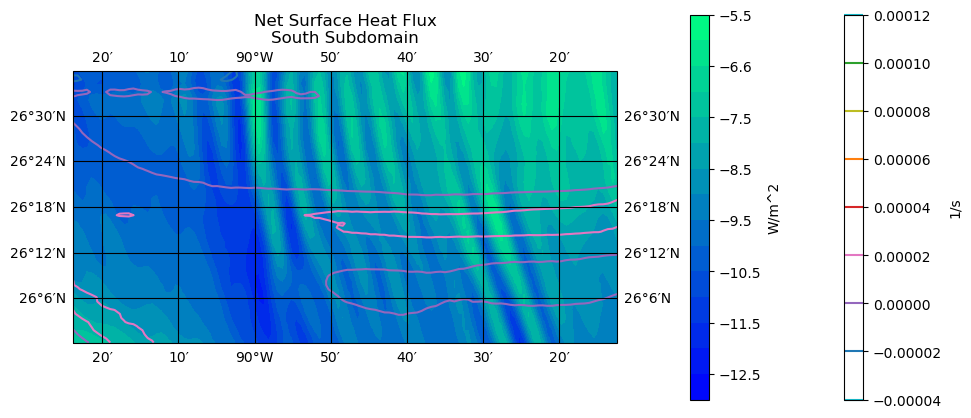

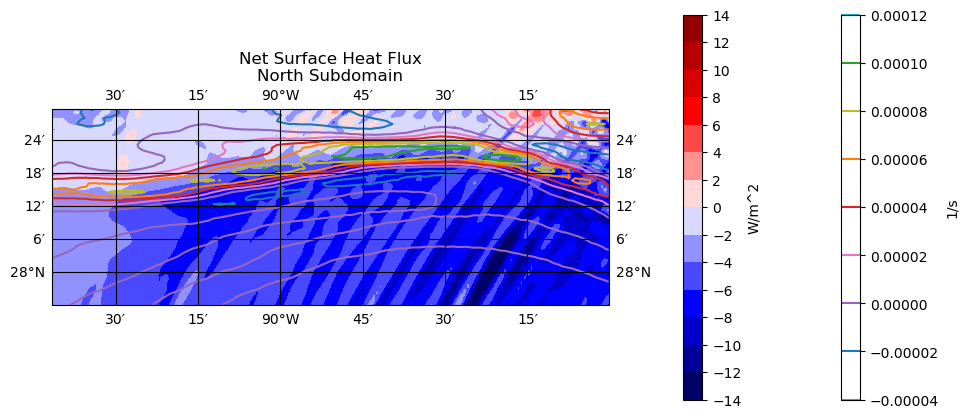

In [40]:
#combined heat fluxes
s_heat = lhf_diff_S + shf_diff_S
n_heat = lhf_diff_N + shf_diff_N 
print(np.nanmean(s_heat))
print(np.nanmean(n_heat))
print(np.nanstd(s_heat))
print(np.nanstd(n_heat))

s_heat_bounds = [-13, -12.5, -12, -11.5, -11, -10.5, -10, -9.5, -9, -8.5, -8, -7.5, -7, -6.6, -6, -5.5]
n_heat_bounds = [-14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14]

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, s_heat, levels =s_heat_bounds, cmap = 'winter')
#cs = ax.contourf(south_lon, south_lat, s_heat)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = s_heat_bounds, label = 'W/m^2')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Surface Heat Flux\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/'
plt.savefig(save_results_to + 'south_heat_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, n_heat, levels =n_heat_bounds, cmap = 'seismic')
#cs = ax.contourf(north_lon, north_lat, n_heat)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = n_heat_bounds, label = 'W/m^2')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Surface Heat Flux\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/'
plt.savefig(save_results_to + 'north_heat_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

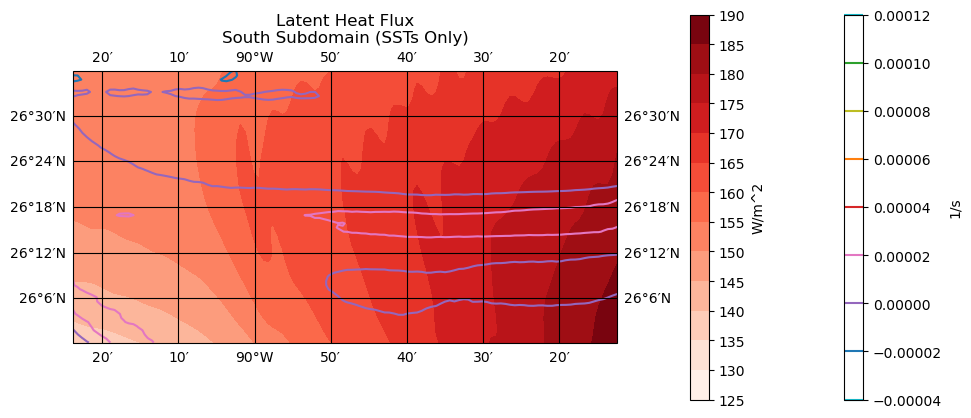

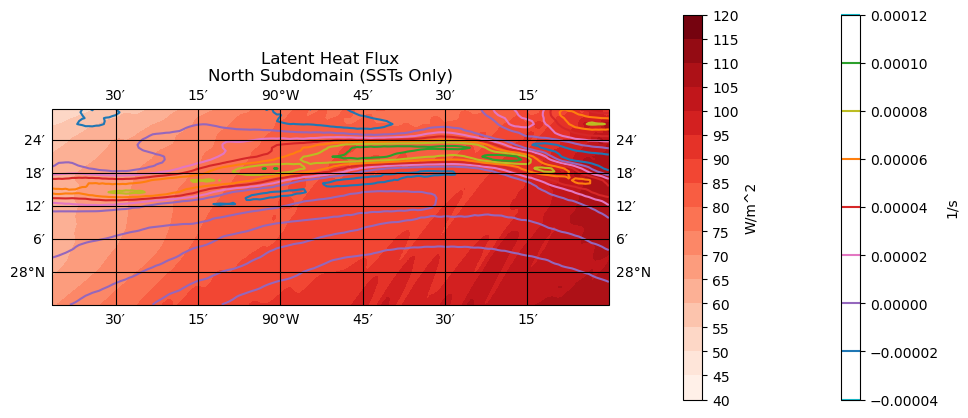

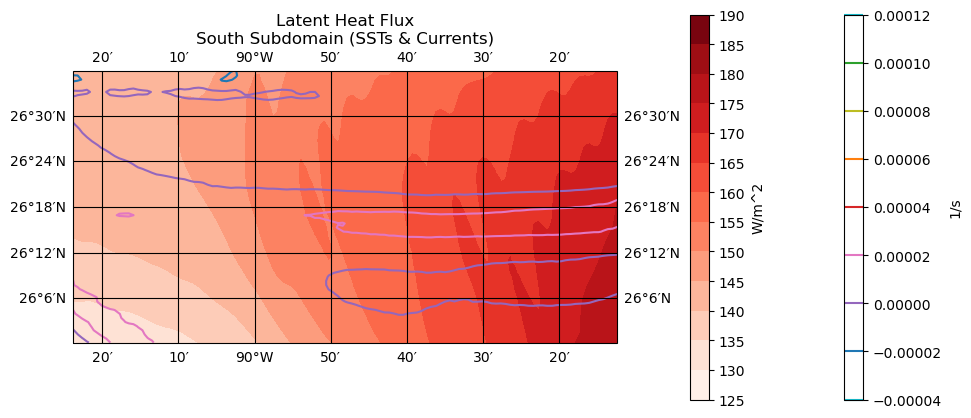

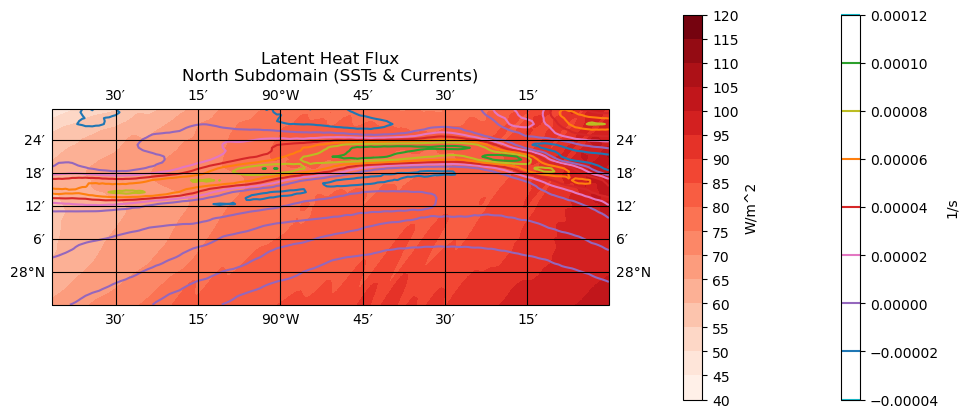

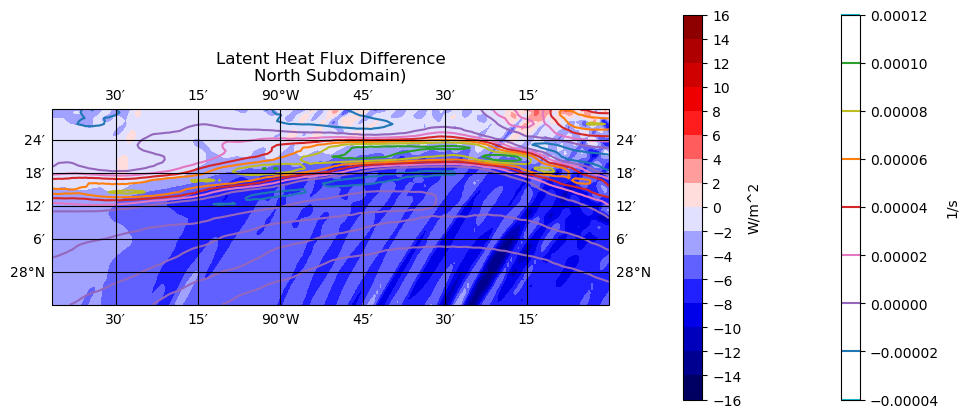

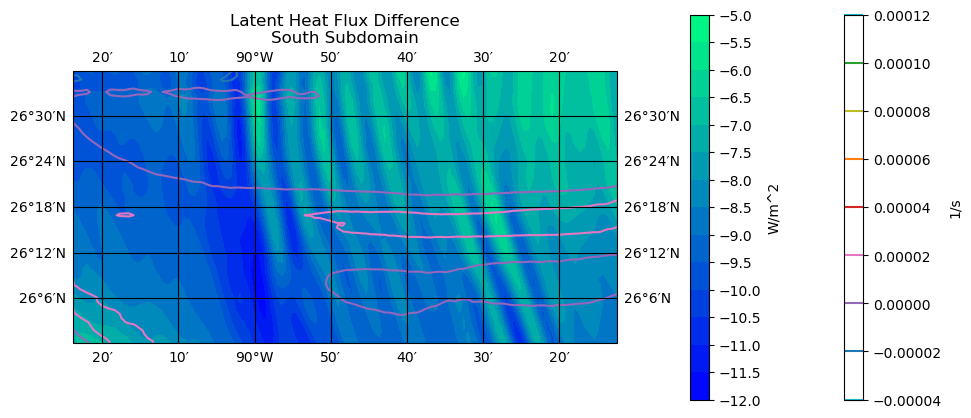

In [31]:
#Plot averages 
'''
#vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
vort_bounds_sfc_N = [-0.00016, -0.00008]

#vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]

vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]
'''
lhf_north = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]
lhf_south = [125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190]
lhf_n_diff = [-16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16]
lhf_s_diff = [-12, -11.5, -11, -10.5, -10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5, -6, -5.5, -5]


#LHF AVG---------------------------------------------------------------
lhf_bounds = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, sst_south_lhf_avg, levels =lhf_south, cmap = 'Reds')
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = lhf_south, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Latent Heat Flux\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/LHF/'
plt.savefig(save_results_to + 'south_lhf_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, sst_north_lhf_avg, levels = lhf_north, cmap = 'Reds')
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = lhf_north, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Latent Heat Flux\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/LHF/'
plt.savefig(save_results_to + 'north_lhf_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, cur_south_lhf_avg, levels = lhf_south, cmap = 'Reds')
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = lhf_south, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Latent Heat Flux\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/LHF/'
plt.savefig(save_results_to + 'south_lhf_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, cur_north_lhf_avg, levels = lhf_north, cmap = 'Reds')
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = lhf_north, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Latent Heat Flux\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/LHF/'
plt.savefig(save_results_to + 'north_lhf_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

diff_bounds = [-16, -14, -12, -10,  -8,  -6,  -4,  -2,  0, 2, 4, 6, 8, 10]
#LHF Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, lhf_diff_N, levels = lhf_n_diff, cmap = 'seismic')
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = lhf_n_diff,  label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Latent Heat Flux Difference\nNorth Subdomain)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/LHF/'
plt.savefig(save_results_to + 'north_lhf_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#bounds = [-16, -14, -12, -10,  -8,  -6,  -4,  -2,  0, 2, 4, 6, 8, 10]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, lhf_diff_S, levels = lhf_s_diff, cmap = 'winter')
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = lhf_s_diff, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Latent Heat Flux Difference\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/LHF/'
plt.savefig(save_results_to + 'south_lhf_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#LHF_S = 140-200
#LHF_N = 40-100
#N_diff = -16 to 4
#S_diff = -16 to 0 


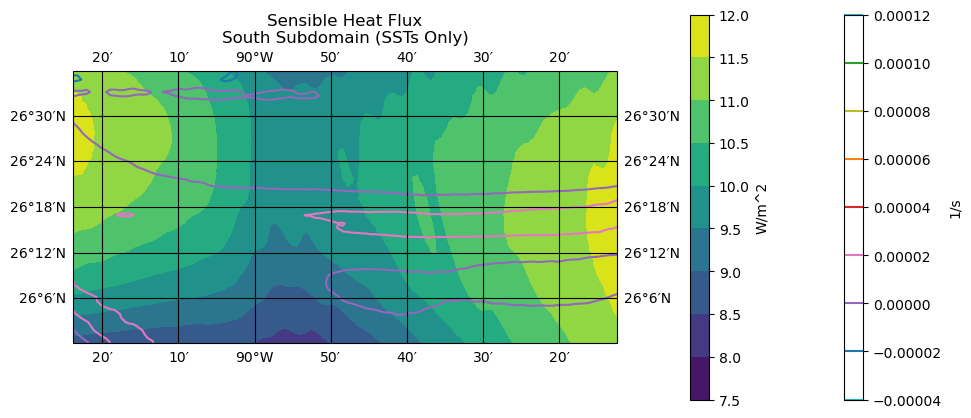

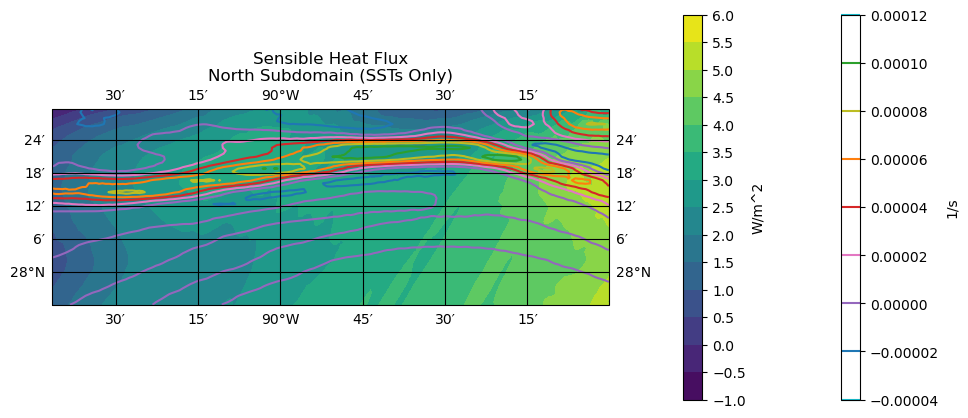

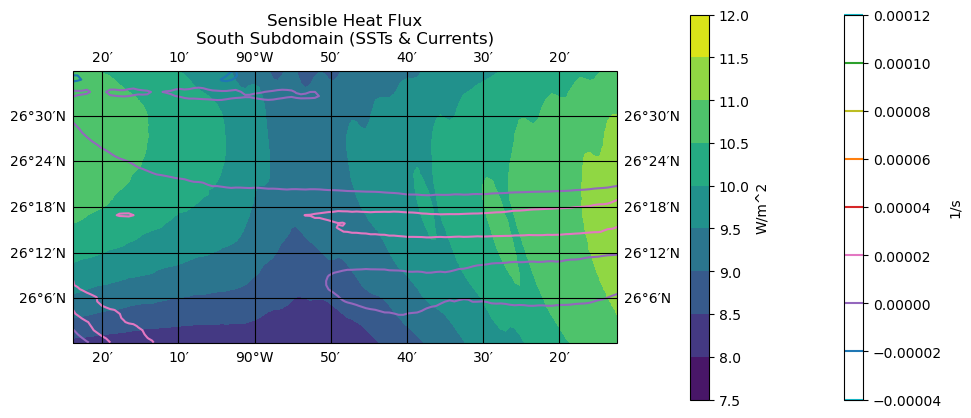

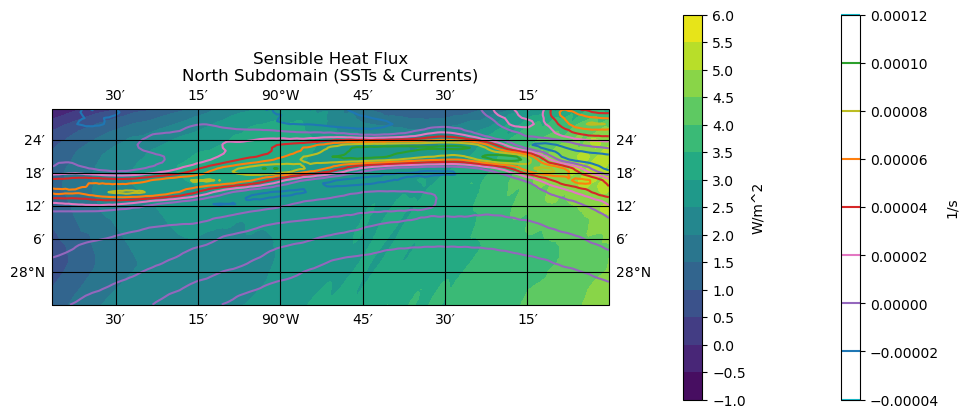

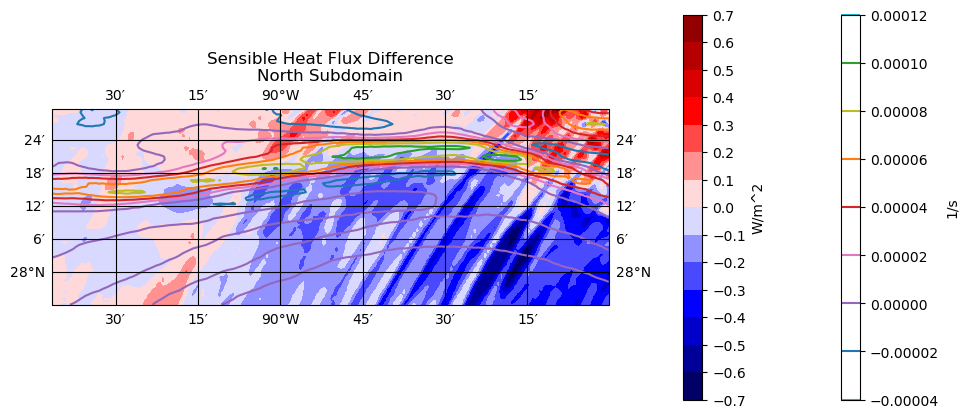

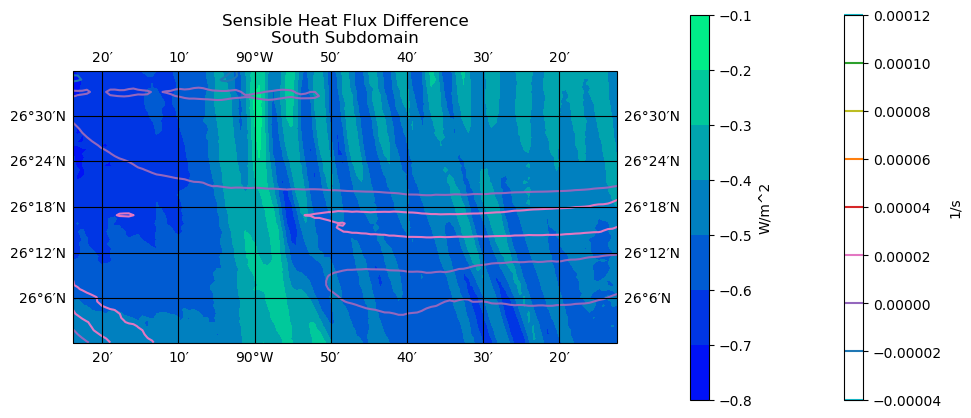

-0.14455605
-0.7492504


In [32]:
shf_north = [-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
shf_south = [ 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]
shf_n_diff = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
shf_s_diff = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]
##############################################################################################
#SHF AVG---------------------------------------------------------------------------
#shf_bounds = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, sst_south_shf_avg, levels = shf_south)
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = shf_south, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Sensible Heat Flux\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/SHF/'
plt.savefig(save_results_to + 'south_shf_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, sst_north_shf_avg, levels = shf_north)
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = shf_north, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Sensible Heat Flux\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/SHF/'
plt.savefig(save_results_to + 'north_shf_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, cur_south_shf_avg, levels = shf_south)
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = shf_south, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Sensible Heat Flux\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/SHF/'
plt.savefig(save_results_to + 'south_shf_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, cur_north_shf_avg, levels = shf_north)
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = shf_north, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Sensible Heat Flux\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/SHF/'
plt.savefig(save_results_to + 'north_shf_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#DIFF_bounds = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
#SHF Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, shf_diff_N, levels = shf_n_diff, cmap = 'seismic')
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = shf_n_diff, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Sensible Heat Flux Difference\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/SHF/'
plt.savefig(save_results_to + 'north_shf_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


shf_s_diff = [-0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]
#bounds = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, shf_diff_S, levels =shf_s_diff,  cmap = 'winter')
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = shf_s_diff, label = 'W/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Sensible Heat Flux Difference\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/SHF/'
plt.savefig(save_results_to + 'south_shf_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

print(np.nanmax(shf_diff_S))
print(np.nanmin(shf_diff_S))

NameError: name 'sst_curl_south10' is not defined

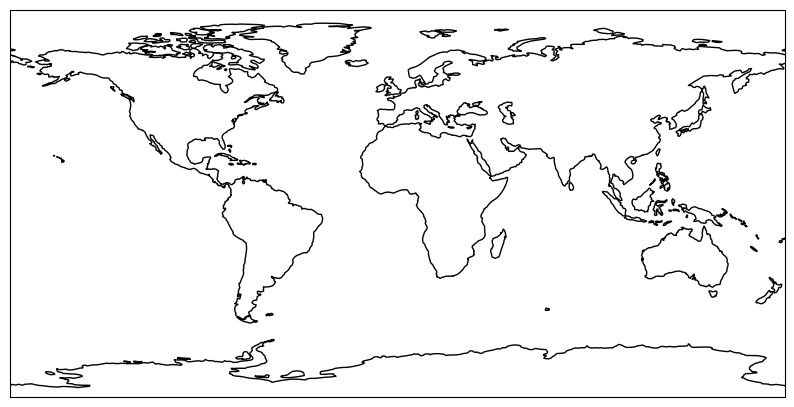

In [15]:
#Plot wind stress curl

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_curl_south10)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], south_sst_u10_10[skip], south_sst_v10_10[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 10 hours\n (SSTs only)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'SST_curl_south_time10.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_curl_south11)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], south_sst_u10_11[skip], south_sst_v10_11[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 11 hours\n (SSTs only)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'SST_curl_south_time11.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_curl_south12)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], south_sst_u10_12[skip], south_sst_v10_12[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 12 hours\n (SSTs only)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'SST_curl_south_time12.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_curl_north10)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], north_sst_u10_10[skip], north_sst_v10_10[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 10 hours\n (SSTs only)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'SST_curl_north_time10.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_curl_north11)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], north_sst_u10_11[skip], north_sst_v10_11[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 11 hours\n (SSTs only)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'SST_curl_north_time11.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_curl_north12)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], north_sst_u10_12[skip], north_sst_v10_12[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 12 hours\n (SSTs only)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'SST_curl_north_time12.png', bbox_inches = 'tight',dpi = 150)
plt.show()






mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_curl_south10)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], south_cur_u10_10[skip], south_cur_v10_10[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 10 hours\n (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'CUR_curl_south_time10.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_curl_south11)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], south_cur_u10_11[skip], south_cur_v10_11[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 11 hours\n (SST & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'CUR_curl_south_time11.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_curl_south12)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], south_cur_u10_12[skip], south_cur_v10_12[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 12 hours\n (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'CUR_curl_south_time12.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_curl_north10)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], north_cur_u10_10[skip], north_cur_v10_10[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 10 hours\n (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'CUR_curl_north_time10.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_curl_north11)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], north_cur_u10_11[skip], north_cur_v10_11[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 11 hours\n (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'CUR_curl_north_time11.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_curl_north12)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], north_cur_u10_12[skip], north_cur_v10_12[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('10 m Wind Stress Curl\nSimulation Time = 12 hours\n (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Winds_10m/'
plt.savefig(save_results_to + 'CUR_curl_north_time12.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [76]:
#Flatten Arrays

#CURL 

sst_curl_north10 = sst_curl_north10.flatten()
sst_curl_south10 = sst_curl_south10.flatten()
sst_curl_north11 = sst_curl_north11.flatten()
sst_curl_south11 = sst_curl_south11.flatten()
sst_curl_north12 = sst_curl_north12.flatten()
sst_curl_south12 = sst_curl_south12.flatten()
sst_curl_north13 = sst_curl_north13.flatten()
sst_curl_south13 = sst_curl_south13.flatten()


cur_curl_north10 = cur_curl_north10.flatten()
cur_curl_south10 = cur_curl_south10.flatten()
cur_curl_north11 = cur_curl_north11.flatten()
cur_curl_south11 = cur_curl_south11.flatten()
cur_curl_north12 = cur_curl_north12.flatten()
cur_curl_south12 = cur_curl_south12.flatten()
cur_curl_north13 = cur_curl_north13.flatten()
cur_curl_south13 = cur_curl_south13.flatten()


sst_curl_north10_mean = np.mean(sst_curl_north10)
sst_curl_south10_mean = np.mean(sst_curl_south10)
sst_curl_north11_mean = np.mean(sst_curl_north11)
sst_curl_south11_mean = np.mean(sst_curl_south11)
sst_curl_north12_mean = np.mean(sst_curl_north12)
sst_curl_south12_mean = np.mean(sst_curl_south12)
sst_curl_north13_mean = np.mean(sst_curl_north13)
sst_curl_south13_mean = np.mean(sst_curl_south13)


cur_curl_north10_mean = np.mean(cur_curl_north10)
cur_curl_south10_mean = np.mean(cur_curl_south10)
cur_curl_north11_mean = np.mean(cur_curl_north11)
cur_curl_south11_mean = np.mean(cur_curl_south11)
cur_curl_north12_mean = np.mean(cur_curl_north12)
cur_curl_south12_mean = np.mean(cur_curl_south12)
cur_curl_north13_mean = np.mean(cur_curl_north13)
cur_curl_south13_mean = np.mean(cur_curl_south13)


sst_curl_north10_std = np.std(sst_curl_north10)
sst_curl_south10_std = np.std(sst_curl_south10)
sst_curl_north11_std = np.std(sst_curl_north11)
sst_curl_south11_std = np.std(sst_curl_south11)
sst_curl_north12_std = np.std(sst_curl_north12)
sst_curl_south12_std = np.std(sst_curl_south12)
sst_curl_north13_std = np.std(sst_curl_north13)
sst_curl_south13_std = np.std(sst_curl_south13)


cur_curl_north10_std = np.std(cur_curl_north10)
cur_curl_south10_std = np.std(cur_curl_south10)
cur_curl_north11_std = np.std(cur_curl_north11)
cur_curl_south11_std = np.std(cur_curl_south11)
cur_curl_north12_std = np.std(cur_curl_north12)
cur_curl_south12_std = np.std(cur_curl_south12)
cur_curl_north13_std = np.std(cur_curl_north13)
cur_curl_south13_std = np.std(cur_curl_south13)

#sst_south_curl_avg = sst_south_curl_avg.flatten()
#sst_north_curl_avg = sst_north_curl_avg.flatten()
#cur_south_curl_avg = cur_south_curl_avg.flatten()
#cur_north_curl_avg = cur_north_curl_avg.flatten()

#sst_south_curl_avg_mean = np.mean(sst_south_curl_avg)
#sst_north_curl_avg_mean = np.mean(sst_north_curl_avg)
#cur_south_curl_avg_mean = np.mean(cur_south_curl_avg)
#cur_north_curl_avg_mean = np.mean(cur_north_curl_avg)

#sst_south_curl_avg_std = np.std(sst_south_curl_avg)
#sst_north_curl_avg_std = np.std(sst_north_curl_avg)
#cur_south_curl_avg_std = np.std(cur_south_curl_avg)
#cur_north_curl_avg_std = np.std(cur_north_curl_avg)

#SHF
sst_shf_north10 = north_sst_shf_10.flatten()
sst_shf_south10 = south_sst_shf_10.flatten()
sst_shf_north11 = north_sst_shf_11.flatten()
sst_shf_south11 = south_sst_shf_11.flatten()
sst_shf_north12 = north_sst_shf_12.flatten()
sst_shf_south12 = south_sst_shf_12.flatten()
sst_shf_north13 = north_sst_shf_13.flatten()
sst_shf_south13 = south_sst_shf_13.flatten()

cur_shf_north10 = north_cur_shf_10.flatten()
cur_shf_south10 = south_cur_shf_10.flatten()
cur_shf_north11 = north_cur_shf_11.flatten()
cur_shf_south11 = south_cur_shf_11.flatten()
cur_shf_north12 = north_cur_shf_12.flatten()
cur_shf_south12 = south_cur_shf_12.flatten()
cur_shf_north13 = north_cur_shf_13.flatten()
cur_shf_south13 = south_cur_shf_13.flatten()

sst_shf_north10_mean = np.mean(sst_shf_north10)
sst_shf_south10_mean = np.mean(sst_shf_south10)
sst_shf_north11_mean = np.mean(sst_shf_north11)
sst_shf_south11_mean = np.mean(sst_shf_south11)
sst_shf_north12_mean = np.mean(sst_shf_north12)
sst_shf_south12_mean = np.mean(sst_shf_south12)
sst_shf_north13_mean = np.mean(sst_shf_north13)
sst_shf_south13_mean = np.mean(sst_shf_south13)

cur_shf_north10_mean = np.mean(cur_shf_north10)
cur_shf_south10_mean = np.mean(cur_shf_south10)
cur_shf_north11_mean = np.mean(cur_shf_north11)
cur_shf_south11_mean = np.mean(cur_shf_south11)
cur_shf_north12_mean = np.mean(cur_shf_north12)
cur_shf_south12_mean = np.mean(cur_shf_south12)
cur_shf_north13_mean = np.mean(cur_shf_north13)
cur_shf_south13_mean = np.mean(cur_shf_south13)


sst_shf_north10_std = np.std(sst_shf_north10)
sst_shf_south10_std = np.std(sst_shf_south10)
sst_shf_north11_std = np.std(sst_shf_north11)
sst_shf_south11_std = np.std(sst_shf_south11)
sst_shf_north12_std = np.std(sst_shf_north12)
sst_shf_south12_std = np.std(sst_shf_south12)
sst_shf_north13_std = np.std(sst_shf_north13)
sst_shf_south13_std = np.std(sst_shf_south13)

cur_shf_north10_std = np.std(cur_shf_north10)
cur_shf_south10_std = np.std(cur_shf_south10)
cur_shf_north11_std = np.std(cur_shf_north11)
cur_shf_south11_std = np.std(cur_shf_south11)
cur_shf_north12_std = np.std(cur_shf_north12)
cur_shf_south12_std = np.std(cur_shf_south12)
cur_shf_north13_std = np.std(cur_shf_north13)
cur_shf_south13_std = np.std(cur_shf_south13)

#sst_south_shf_avg = sst_south_shf_avg.flatten()
#sst_north_shf_avg = sst_north_shf_avg.flatten()
#cur_south_shf_avg = cur_south_shf_avg.flatten()
#cur_north_shf_avg = cur_north_shf_avg.flatten()

#sst_south_shf_avg_mean = np.mean(sst_south_shf_avg)
#sst_north_shf_avg_mean = np.mean(sst_north_shf_avg)
#cur_south_shf_avg_mean = np.mean(cur_south_shf_avg)
#cur_north_shf_avg_mean = np.mean(cur_north_shf_avg)

#sst_south_shf_avg_std = np.std(sst_south_shf_avg)
#sst_north_shf_avg_std = np.std(sst_north_shf_avg)
#cur_south_shf_avg_std = np.std(cur_south_shf_avg)
#cur_north_shf_avg_std = np.std(cur_north_shf_avg)


#LHF

sst_lhf_north10 = north_sst_lhf_10.flatten()
sst_lhf_south10 = south_sst_lhf_10.flatten()
sst_lhf_north11 = north_sst_lhf_11.flatten()
sst_lhf_south11 = south_sst_lhf_11.flatten()
sst_lhf_north12 = north_sst_lhf_12.flatten()
sst_lhf_south12 = south_sst_lhf_12.flatten()
sst_lhf_north13 = north_sst_lhf_13.flatten()
sst_lhf_south13 = south_sst_lhf_13.flatten()


cur_lhf_north10 = north_cur_lhf_10.flatten()
cur_lhf_south10 = south_cur_lhf_10.flatten()
cur_lhf_north11 = north_cur_lhf_11.flatten()
cur_lhf_south11 = south_cur_lhf_11.flatten()
cur_lhf_north12 = north_cur_lhf_12.flatten()
cur_lhf_south12 = south_cur_lhf_12.flatten()
cur_lhf_north13 = north_cur_lhf_13.flatten()
cur_lhf_south13 = south_cur_lhf_13.flatten()


sst_lhf_north10_mean = np.mean(sst_lhf_north10)
sst_lhf_south10_mean = np.mean(sst_lhf_south10)
sst_lhf_north11_mean = np.mean(sst_lhf_north11)
sst_lhf_south11_mean = np.mean(sst_lhf_south11)
sst_lhf_north12_mean = np.mean(sst_lhf_north12)
sst_lhf_south12_mean = np.mean(sst_lhf_south12)
sst_lhf_north13_mean = np.mean(sst_lhf_north13)
sst_lhf_south13_mean = np.mean(sst_lhf_south13)


cur_lhf_north10_mean = np.mean(cur_lhf_north10)
cur_lhf_south10_mean = np.mean(cur_lhf_south10)
cur_lhf_north11_mean = np.mean(cur_lhf_north11)
cur_lhf_south11_mean = np.mean(cur_lhf_south11)
cur_lhf_north12_mean = np.mean(cur_lhf_north12)
cur_lhf_south12_mean = np.mean(cur_lhf_south12)
cur_lhf_north13_mean = np.mean(cur_lhf_north13)
cur_lhf_south13_mean = np.mean(cur_lhf_south13)

sst_lhf_north10_std = np.std(sst_lhf_north10)
sst_lhf_south10_std = np.std(sst_lhf_south10)
sst_lhf_north11_std = np.std(sst_lhf_north11)
sst_lhf_south11_std = np.std(sst_lhf_south11)
sst_lhf_north12_std = np.std(sst_lhf_north12)
sst_lhf_south12_std = np.std(sst_lhf_south12)
sst_lhf_north13_std = np.std(sst_lhf_north13)
sst_lhf_south13_std = np.std(sst_lhf_south13)

cur_lhf_north10_std = np.std(cur_lhf_north10)
cur_lhf_south10_std = np.std(cur_lhf_south10)
cur_lhf_north11_std = np.std(cur_lhf_north11)
cur_lhf_south11_std = np.std(cur_lhf_south11)
cur_lhf_north12_std = np.std(cur_lhf_north12)
cur_lhf_south12_std = np.std(cur_lhf_south12)
cur_lhf_north13_std = np.std(cur_lhf_north13)
cur_lhf_south13_std = np.std(cur_lhf_south13)

#sst_south_lhf_avg = sst_south_lhf_avg.flatten()
#sst_north_lhf_avg = sst_north_lhf_avg.flatten()
#cur_south_lhf_avg = cur_south_lhf_avg.flatten()
#cur_north_lhf_avg = cur_north_lhf_avg.flatten()

#sst_south_lhf_avg_mean = np.mean(sst_south_lhf_avg)
#sst_north_lhf_avg_mean = np.mean(sst_north_lhf_avg)
#cur_south_lhf_avg_mean = np.mean(cur_south_lhf_avg)
#cur_north_lhf_avg_mean = np.mean(cur_north_lhf_avg)

#sst_south_lhf_avg_std = np.std(sst_south_lhf_avg)
#sst_north_lhf_avg_std = np.std(sst_north_lhf_avg)
#cur_south_lhf_avg_std = np.std(cur_south_lhf_avg)
#cur_north_lhf_avg_std = np.std(cur_north_lhf_avg)

'''
sst_south_shf_mean = [sst_shf_south7_mean, sst_shf_south8_mean, sst_shf_south9_mean, sst_shf_south10_mean, sst_shf_south11_mean, sst_shf_south12_mean, sst_shf_south13_mean, sst_shf_south14_mean, sst_shf_south15_mean, sst_shf_south16_mean, sst_shf_south17_mean, sst_shf_south18_mean, sst_shf_south19_mean, sst_shf_south20_mean, sst_shf_south21_mean, sst_shf_south22_mean, sst_shf_south23_mean, sst_shf_south24_mean]
sst_north_shf_mean = [sst_shf_north7_mean, sst_shf_north8_mean, sst_shf_north9_mean, sst_shf_north10_mean, sst_shf_north11_mean, sst_shf_north12_mean, sst_shf_north13_mean, sst_shf_north14_mean, sst_shf_north15_mean, sst_shf_north16_mean, sst_shf_north17_mean, sst_shf_north18_mean, sst_shf_north19_mean, sst_shf_north20_mean, sst_shf_north21_mean, sst_shf_north22_mean, sst_shf_north23_mean, sst_shf_north24_mean]
cur_south_shf_mean = [cur_shf_south7_mean, cur_shf_south8_mean, cur_shf_south9_mean, cur_shf_south10_mean, cur_shf_south11_mean, cur_shf_south12_mean, cur_shf_south13_mean, cur_shf_south14_mean,  cur_shf_south15_mean, cur_shf_south16_mean, cur_shf_south17_mean, cur_shf_south18_mean, cur_shf_south19_mean, cur_shf_south20_mean, cur_shf_south21_mean, cur_shf_south22_mean, cur_shf_south23_mean, cur_shf_south24_mean]
cur_north_shf_mean = [cur_shf_north7_mean, cur_shf_north8_mean, cur_shf_north9_mean, cur_shf_north10_mean, cur_shf_north11_mean, cur_shf_north12_mean, cur_shf_north13_mean, cur_shf_north14_mean, cur_shf_north15_mean, cur_shf_north16_mean, cur_shf_north17_mean, cur_shf_north18_mean, cur_shf_north19_mean, cur_shf_north20_mean, cur_shf_north21_mean, cur_shf_north22_mean, cur_shf_north23_mean, cur_shf_north24_mean]
sst_south_shf_std = [sst_shf_south7_std, sst_shf_south8_std, sst_shf_south9_std, sst_shf_south10_std, sst_shf_south11_std, sst_shf_south12_std, sst_shf_south13_std, sst_shf_south14_std, sst_shf_south15_std, sst_shf_south16_std, sst_shf_south17_std, sst_shf_south18_std, sst_shf_south19_std, sst_shf_south20_std, sst_shf_south21_std, sst_shf_south22_std, sst_shf_south23_std, sst_shf_south24_std]
sst_north_shf_std = [sst_shf_north7_std, sst_shf_north8_std, sst_shf_north9_std, sst_shf_north10_std, sst_shf_north11_std, sst_shf_north12_std, sst_shf_north13_std, sst_shf_north14_std, sst_shf_north15_std, sst_shf_north16_std, sst_shf_north17_std, sst_shf_north18_std, sst_shf_north19_std, sst_shf_north20_std, sst_shf_north21_std, sst_shf_north22_std, sst_shf_north23_std, sst_shf_north24_std]
cur_south_shf_std = [cur_shf_south7_std, cur_shf_south8_std, cur_shf_south9_std, cur_shf_south10_std, cur_shf_south11_std, cur_shf_south12_std, cur_shf_south13_std, cur_shf_south14_std, cur_shf_south15_std, cur_shf_south16_std, cur_shf_south17_std, cur_shf_south18_std, cur_shf_south19_std, cur_shf_south20_std, cur_shf_south21_std, cur_shf_south22_std, cur_shf_south23_std, cur_shf_south24_std]
cur_north_shf_std = [cur_shf_north7_std, cur_shf_north8_std, cur_shf_north9_std, cur_shf_north10_std, cur_shf_north11_std, cur_shf_north12_std, cur_shf_north13_std, cur_shf_north14_std, cur_shf_north15_std, cur_shf_north16_std, cur_shf_north17_std, cur_shf_north18_std, cur_shf_north19_std, cur_shf_north20_std, cur_shf_north21_std, cur_shf_north22_std, cur_shf_north23_std, cur_shf_north24_std]

sst_south_lhf_mean = [sst_lhf_south7_mean, sst_lhf_south8_mean, sst_lhf_south9_mean, sst_lhf_south10_mean, sst_lhf_south11_mean, sst_lhf_south12_mean, sst_lhf_south13_mean, sst_lhf_south14_mean, sst_lhf_south15_mean, sst_lhf_south16_mean, sst_lhf_south17_mean, sst_lhf_south18_mean, sst_lhf_south19_mean, sst_lhf_south20_mean, sst_lhf_south21_mean, sst_lhf_south22_mean, sst_lhf_south23_mean, sst_lhf_south24_mean]
sst_north_lhf_mean = [sst_lhf_north7_mean, sst_lhf_north8_mean, sst_lhf_north9_mean, sst_lhf_north10_mean, sst_lhf_north11_mean, sst_lhf_north12_mean, sst_lhf_north13_mean, sst_lhf_north14_mean, sst_lhf_north15_mean, sst_lhf_north16_mean, sst_lhf_north17_mean, sst_lhf_north18_mean, sst_lhf_north19_mean, sst_lhf_north20_mean, sst_lhf_north21_mean, sst_lhf_north22_mean, sst_lhf_north23_mean, sst_lhf_north24_mean]
cur_south_lhf_mean = [cur_lhf_south7_mean, cur_lhf_south8_mean, cur_lhf_south9_mean, cur_lhf_south10_mean, cur_lhf_south11_mean, cur_lhf_south12_mean, cur_lhf_south13_mean, cur_lhf_south14_mean, cur_lhf_south15_mean, cur_lhf_south16_mean, cur_lhf_south17_mean, cur_lhf_south18_mean, cur_lhf_south19_mean, cur_lhf_south20_mean, cur_lhf_south21_mean, cur_lhf_south22_mean, cur_lhf_south23_mean, cur_lhf_south24_mean]
cur_north_lhf_mean = [cur_lhf_north7_mean, cur_lhf_north8_mean, cur_lhf_north9_mean, cur_lhf_north10_mean, cur_lhf_north11_mean, cur_lhf_north12_mean, cur_lhf_north13_mean, cur_lhf_north14_mean, cur_lhf_north15_mean, cur_lhf_north16_mean, cur_lhf_north17_mean, cur_lhf_north18_mean, cur_lhf_north19_mean, cur_lhf_north20_mean, cur_lhf_north21_mean, cur_lhf_north22_mean, cur_lhf_north23_mean, cur_lhf_north24_mean]
sst_south_lhf_std = [sst_lhf_south7_std, sst_lhf_south8_std, sst_lhf_south9_std, sst_lhf_south10_std, sst_lhf_south11_std, sst_lhf_south12_std, sst_lhf_south13_std, sst_lhf_south14_std, sst_lhf_south15_std, sst_lhf_south16_std, sst_lhf_south17_std, sst_lhf_south18_std, sst_lhf_south19_std, sst_lhf_south20_std, sst_lhf_south21_std, sst_lhf_south22_std, sst_lhf_south23_std, sst_lhf_south24_std]
sst_north_lhf_std = [sst_lhf_north7_std, sst_lhf_north8_std, sst_lhf_north9_std, sst_lhf_north10_std, sst_lhf_north11_std, sst_lhf_north12_std, sst_lhf_north13_std, sst_lhf_north14_std, sst_lhf_north15_std, sst_lhf_north16_std, sst_lhf_north17_std, sst_lhf_north18_std, sst_lhf_north19_std, sst_lhf_north20_std, sst_lhf_north21_std, sst_lhf_north22_std, sst_lhf_north23_std, sst_lhf_north24_std]
cur_south_lhf_std = [cur_lhf_south7_std, cur_lhf_south8_std, cur_lhf_south9_std, cur_lhf_south10_std, cur_lhf_south11_std, cur_lhf_south12_std, cur_lhf_south13_std, cur_lhf_south14_std, cur_lhf_south15_std, cur_lhf_south16_std, cur_lhf_south17_std, cur_lhf_south18_std, cur_lhf_south19_std, cur_lhf_south20_std, cur_lhf_south21_std, cur_lhf_south22_std, cur_lhf_south23_std, cur_lhf_south24_std]
cur_north_lhf_std = [cur_lhf_north7_std, cur_lhf_north8_std, cur_lhf_north9_std, cur_lhf_north10_std, cur_lhf_north11_std, cur_lhf_north12_std, cur_lhf_north13_std, cur_lhf_north14_std, cur_lhf_north15_std, cur_lhf_north16_std, cur_lhf_north17_std, cur_lhf_north18_std, cur_lhf_north19_std, cur_lhf_north20_std, cur_lhf_north21_std, cur_lhf_north22_std, cur_lhf_north23_std, cur_lhf_north24_std]

sst_south_curl_mean = [sst_curl_south7_mean, sst_curl_south8_mean, sst_curl_south9_mean, sst_curl_south10_mean, sst_curl_south11_mean, sst_curl_south12_mean, sst_curl_south13_mean, sst_curl_south14_mean, sst_curl_south15_mean, sst_curl_south16_mean, sst_curl_south17_mean, sst_curl_south18_mean, sst_curl_south19_mean, sst_curl_south20_mean, sst_curl_south21_mean, sst_curl_south22_mean, sst_curl_south23_mean, sst_curl_south24_mean]
sst_north_curl_mean = [sst_curl_north7_mean, sst_curl_north8_mean, sst_curl_north9_mean, sst_curl_north10_mean, sst_curl_north11_mean, sst_curl_north12_mean, sst_curl_north13_mean, sst_curl_north14_mean, sst_curl_north15_mean, sst_curl_north16_mean, sst_curl_north17_mean, sst_curl_north18_mean, sst_curl_north19_mean, sst_curl_north20_mean, sst_curl_north21_mean, sst_curl_north22_mean, sst_curl_north23_mean, sst_curl_north24_mean]
cur_south_curl_mean = [cur_curl_south7_mean, cur_curl_south8_mean, cur_curl_south9_mean, cur_curl_south10_mean, cur_curl_south11_mean, cur_curl_south12_mean, cur_curl_south13_mean, cur_curl_south14_mean, cur_curl_south15_mean, cur_curl_south16_mean, cur_curl_south17_mean, cur_curl_south18_mean, cur_curl_south19_mean, cur_curl_south20_mean, cur_curl_south21_mean, cur_curl_south22_mean, cur_curl_south23_mean, cur_curl_south24_mean]
cur_north_curl_mean = [cur_curl_north7_mean, cur_curl_north8_mean, cur_curl_north9_mean, cur_curl_north10_mean, cur_curl_north11_mean, cur_curl_north12_mean, cur_curl_north13_mean, cur_curl_north14_mean, cur_curl_north15_mean, cur_curl_north16_mean, cur_curl_north17_mean, cur_curl_north18_mean, cur_curl_north19_mean, cur_curl_north20_mean, cur_curl_north21_mean, cur_curl_north22_mean, cur_curl_north23_mean, cur_curl_north24_mean]
sst_south_curl_std = [sst_curl_south7_std, sst_curl_south8_std, sst_curl_south9_std, sst_curl_south10_std, sst_curl_south11_std, sst_curl_south12_std, sst_curl_south13_std, sst_curl_south14_std, sst_curl_south15_std, sst_curl_south16_std, sst_curl_south17_std, sst_curl_south18_std, sst_curl_south19_std, sst_curl_south20_std, sst_curl_south21_std, sst_curl_south22_std, sst_curl_south23_std, sst_curl_south24_std]
sst_north_curl_std = [sst_curl_north7_std, sst_curl_north8_std, sst_curl_north9_std, sst_curl_north10_std, sst_curl_north11_std, sst_curl_north12_std, sst_curl_north13_std, sst_curl_north14_std, sst_curl_north15_std, sst_curl_north16_std, sst_curl_north17_std, sst_curl_north18_std, sst_curl_north19_std, sst_curl_north20_std, sst_curl_north21_std, sst_curl_north22_std, sst_curl_north23_std, sst_curl_north24_std]
cur_south_curl_std = [cur_curl_south7_std, cur_curl_south8_std, cur_curl_south9_std, cur_curl_south10_std, cur_curl_south11_std, cur_curl_south12_std, cur_curl_south13_std, cur_curl_south14_std, cur_curl_south15_std, cur_curl_south16_std, cur_curl_south17_std, cur_curl_south18_std, cur_curl_south19_std, cur_curl_south20_std, cur_curl_south21_std, cur_curl_south22_std, cur_curl_south23_std, cur_curl_south24_std]
cur_north_curl_std = [cur_curl_north7_std, cur_curl_north8_std, cur_curl_north9_std, cur_curl_north10_std, cur_curl_north11_std, cur_curl_north12_std, cur_curl_north13_std, cur_curl_north14_std, cur_curl_north15_std, cur_curl_north16_std, cur_curl_north17_std, cur_curl_north18_std, cur_curl_north19_std, cur_curl_north20_std, cur_curl_north21_std, cur_curl_north22_std, cur_curl_north23_std, cur_curl_north24_std]
'''

<Figure size 640x480 with 0 Axes>

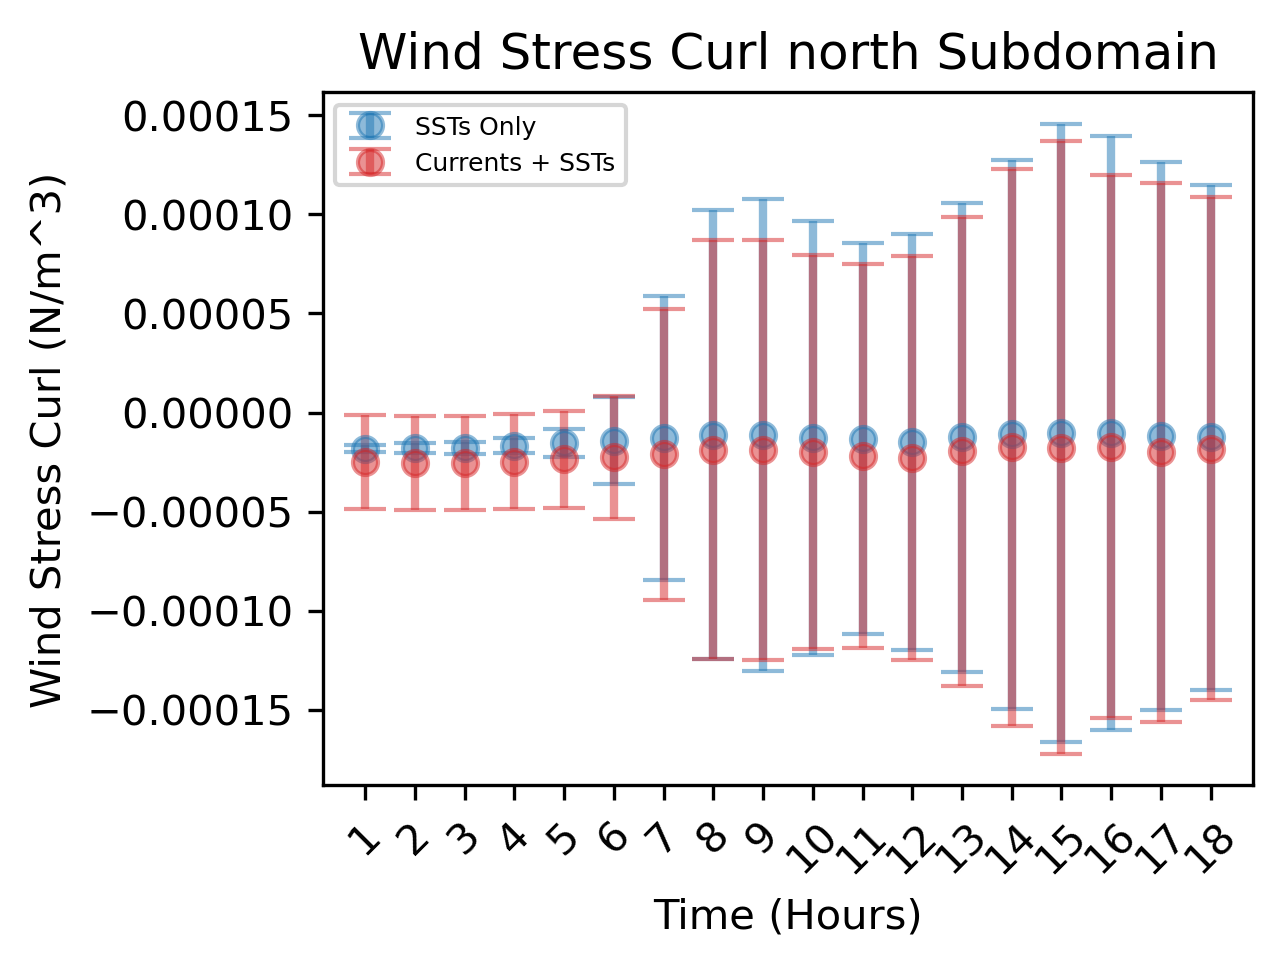

<Figure size 640x480 with 0 Axes>

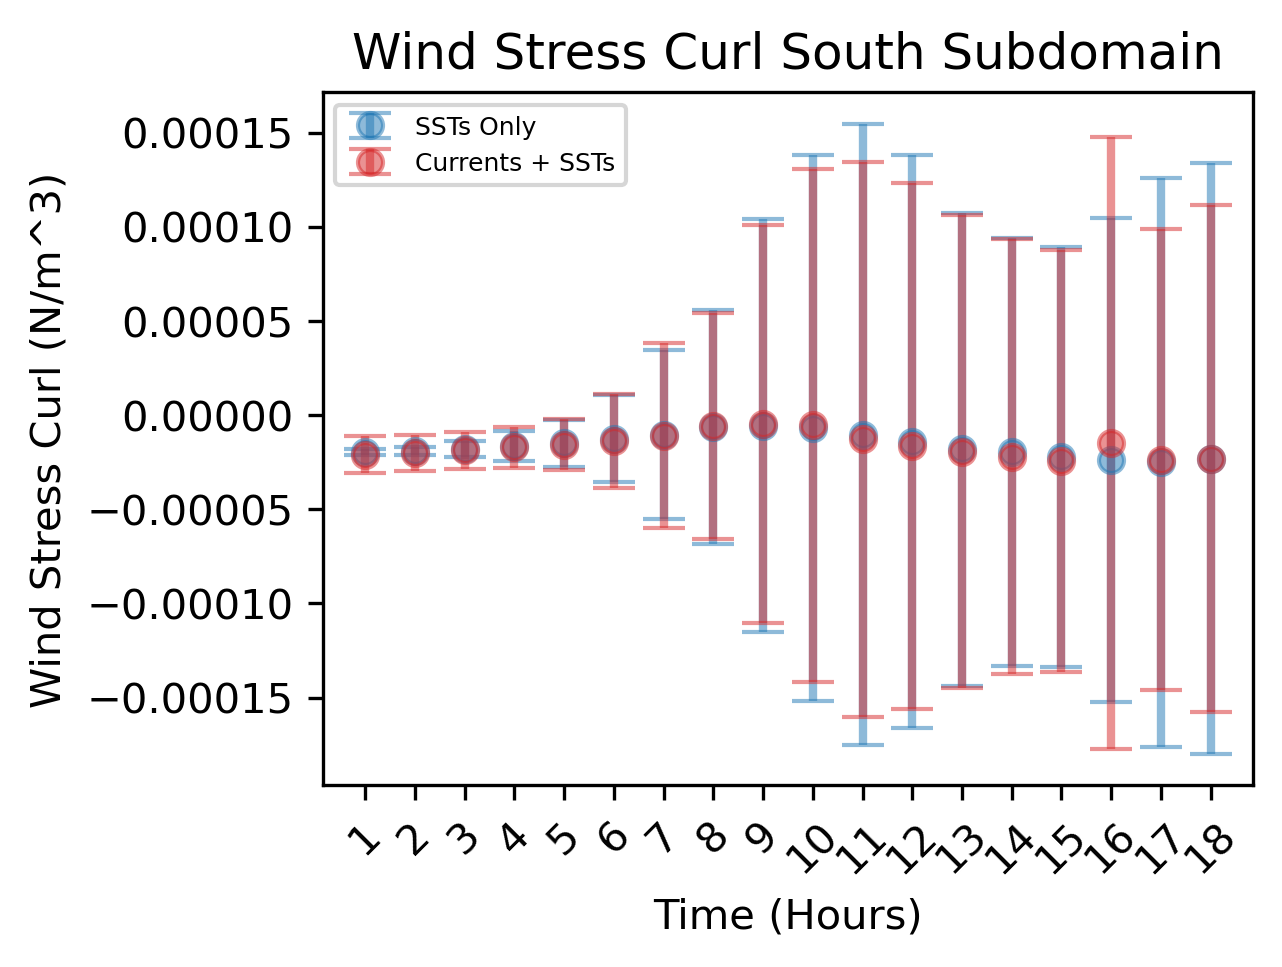

In [80]:
#Wind Stress Curl North
fig = plt.figure()
figure(figsize=(4,3), dpi=300)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
y1 = sst_north_curl_mean
yerr1 = sst_north_curl_std
y2 = cur_north_curl_mean
yerr2 = cur_north_curl_std
plt.errorbar(x, y1, yerr1, fmt='o', linewidth=2, capsize=5, color = 'tab:blue', alpha = 0.5, label ='SSTs Only' )
plt.errorbar(x, y2, yerr2, fmt='o', linewidth=2, capsize=5, color = 'tab:red', alpha = 0.5, label = 'Currents + SSTs')
plt.xticks(x, labels = labels, rotation = 45)
plt.legend(fontsize = "6", loc="upper left")
plt.xlabel('Time (Hours)')
plt.ylabel('Wind Stress Curl (N/m^3)')
plt.title('Wind Stress Curl north Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Fluxes/'
plt.savefig(save_results_to + 'diff_stressCurl_north.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#Wind Stress Curl South
fig = plt.figure()
figure(figsize=(4,3), dpi=300)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
y1 = sst_south_curl_mean
yerr1 = sst_south_curl_std
y2 = cur_south_curl_mean
yerr2 = cur_south_curl_std
plt.errorbar(x, y1, yerr1, fmt='o', linewidth=2, capsize=5, color = 'tab:blue', alpha = 0.5, label ='SSTs Only' )
plt.errorbar(x, y2, yerr2, fmt='o', linewidth=2, capsize=5, color = 'tab:red', alpha = 0.5, label = 'Currents + SSTs')
plt.xticks(x, labels = labels, rotation = 45)
plt.legend(fontsize = "6", loc="upper left")
plt.xlabel('Time (Hours)')
plt.ylabel('Wind Stress Curl (N/m^3)')
plt.title('Wind Stress Curl South Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Fluxes/'
plt.savefig(save_results_to + 'diff_stressCurl_south.png', bbox_inches = 'tight',dpi = 150)
plt.show()


<Figure size 640x480 with 0 Axes>

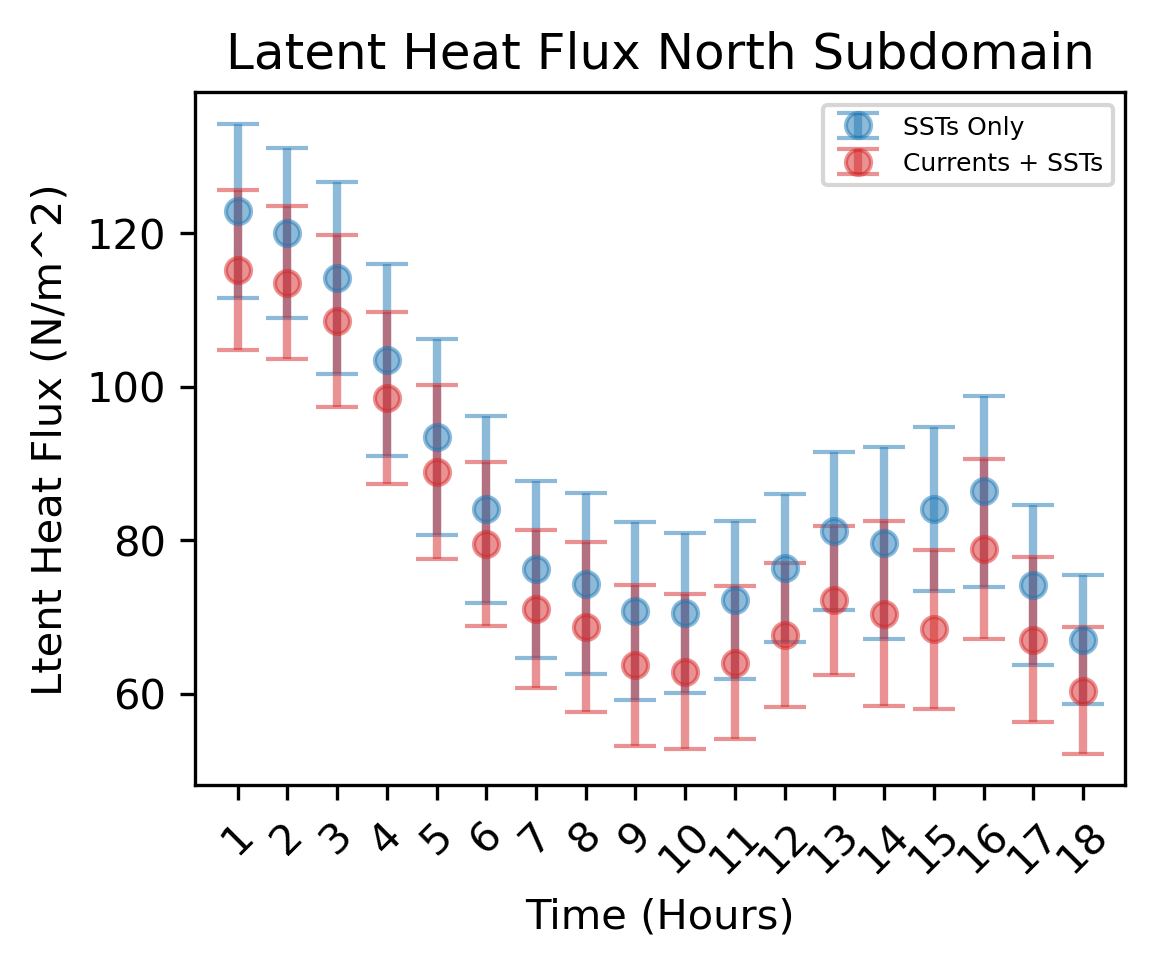

<Figure size 640x480 with 0 Axes>

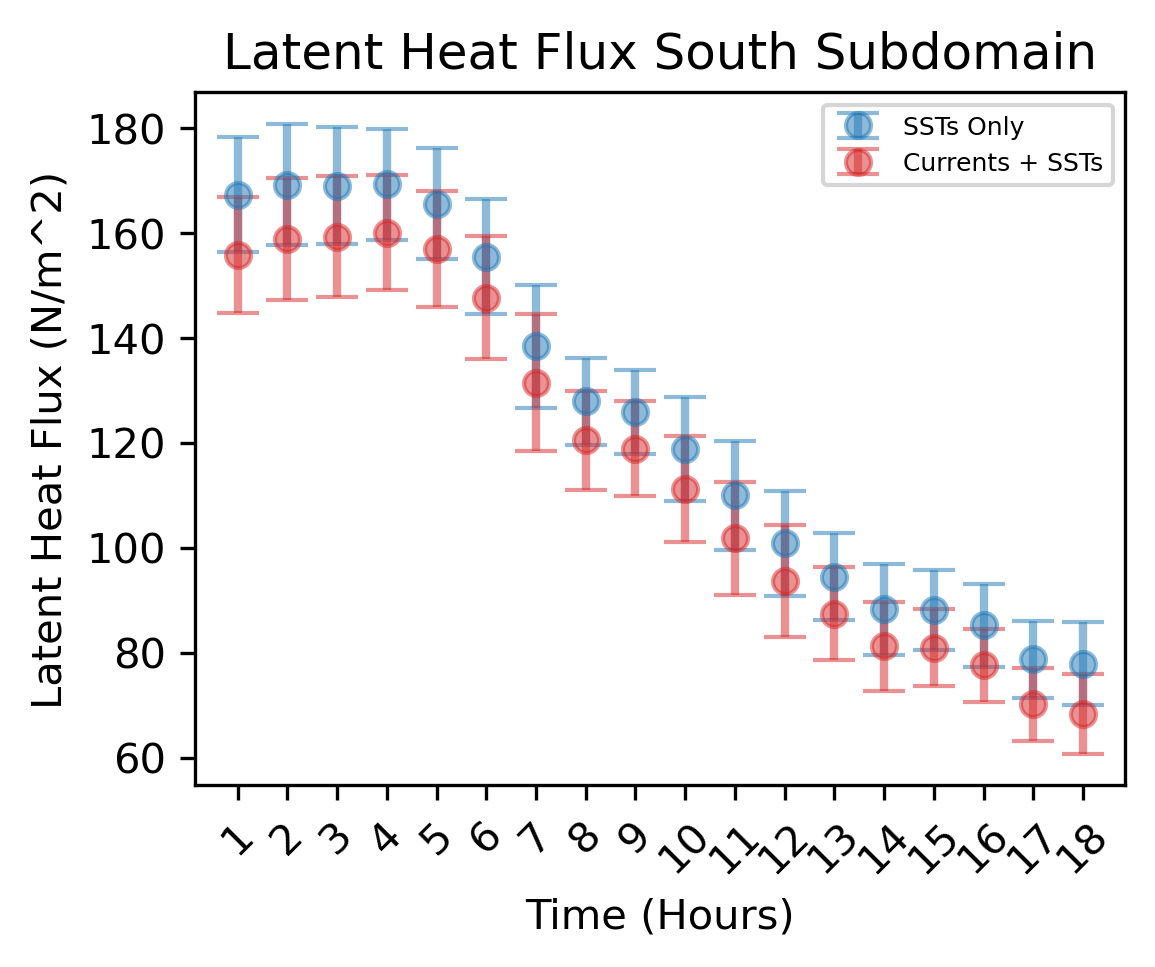

In [81]:
#LHF North
fig = plt.figure()
figure(figsize=(4,3), dpi=300)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
y1 = sst_north_lhf_mean
yerr1 = sst_north_lhf_std
y2 = cur_north_lhf_mean
yerr2 = cur_north_lhf_std
plt.errorbar(x, y1, yerr1, fmt='o', linewidth=2, capsize=5, color = 'tab:blue', alpha = 0.5, label ='SSTs Only' )
plt.errorbar(x, y2, yerr2, fmt='o', linewidth=2, capsize=5, color = 'tab:red', alpha = 0.5, label = 'Currents + SSTs')
plt.xticks(x, labels = labels, rotation = 45)
plt.legend(fontsize = "6", loc="upper right")
plt.xlabel('Time (Hours)')
plt.ylabel('Ltent Heat Flux (N/m^2)')
plt.title('Latent Heat Flux North Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Fluxes/'
plt.savefig(save_results_to + 'diff_LHF_north.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#LHF South
fig = plt.figure()
figure(figsize=(4,3), dpi=300)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
y1 = sst_south_lhf_mean
yerr1 = sst_south_lhf_std
y2 = cur_south_lhf_mean
yerr2 = cur_south_lhf_std
plt.errorbar(x, y1, yerr1, fmt='o', linewidth=2, capsize=5, color = 'tab:blue', alpha = 0.5, label ='SSTs Only' )
plt.errorbar(x, y2, yerr2, fmt='o', linewidth=2, capsize=5, color = 'tab:red', alpha = 0.5, label = 'Currents + SSTs')
plt.xticks(x, labels = labels, rotation = 45)
plt.legend(fontsize = "6", loc="upper right")
plt.xlabel('Time (Hours)')
plt.ylabel('Latent Heat Flux (N/m^2)')
plt.title('Latent Heat Flux South Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Fluxes/'
plt.savefig(save_results_to + 'diff_LHF_south.png', bbox_inches = 'tight',dpi = 150)
plt.show()

<Figure size 640x480 with 0 Axes>

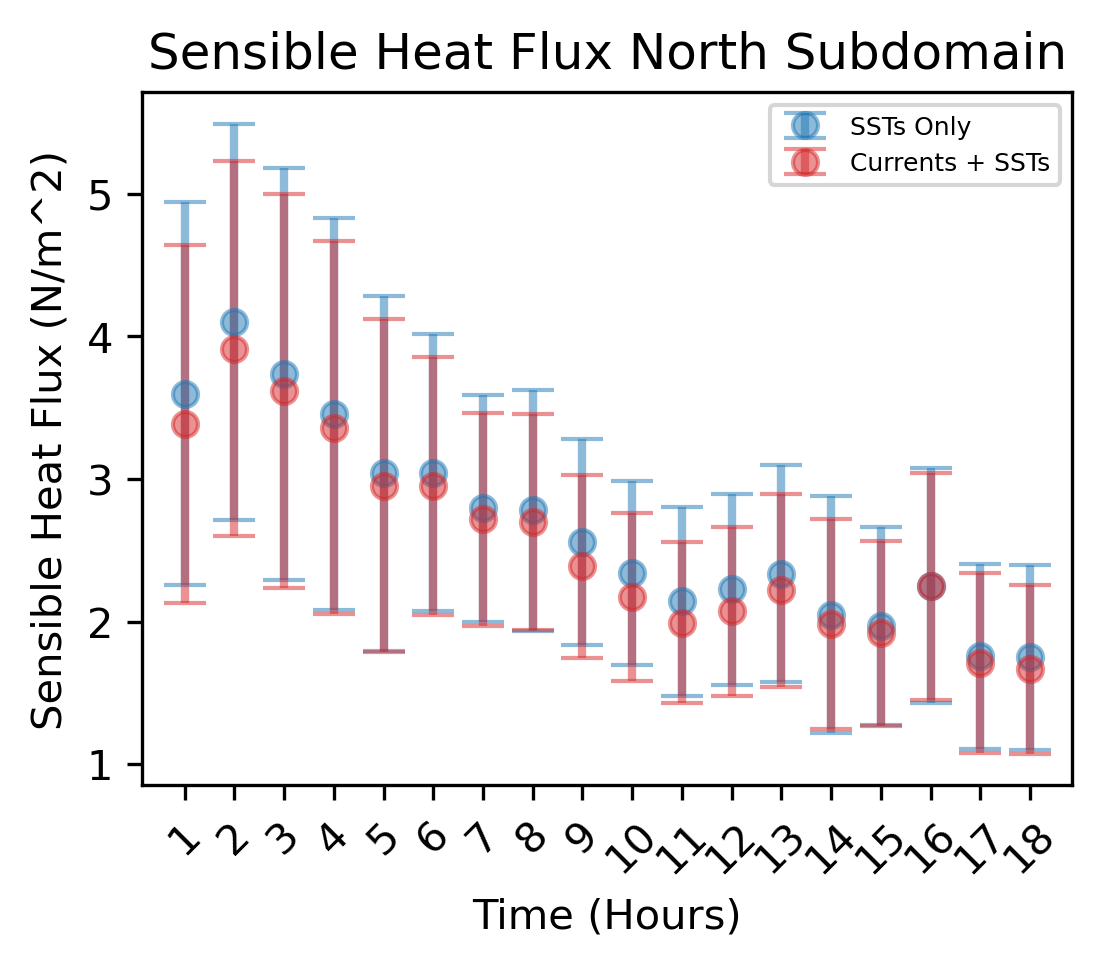

<Figure size 640x480 with 0 Axes>

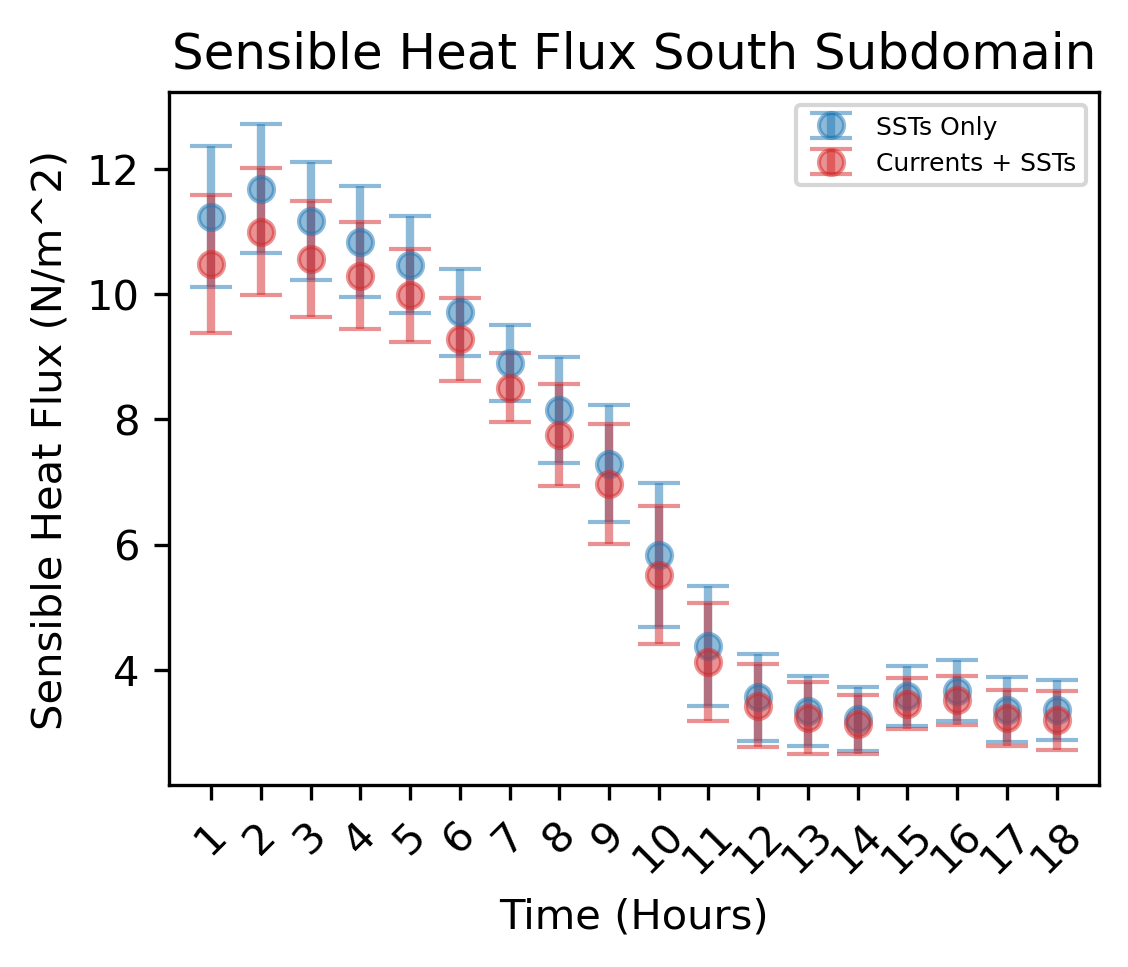

In [82]:
#SHF North
fig = plt.figure()
figure(figsize=(4,3), dpi=300)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
y1 = sst_north_shf_mean
yerr1 = sst_north_shf_std
y2 = cur_north_shf_mean
yerr2 = cur_north_shf_std
plt.errorbar(x, y1, yerr1, fmt='o', linewidth=2, capsize=5, color = 'tab:blue', alpha = 0.5, label ='SSTs Only' )
plt.errorbar(x, y2, yerr2, fmt='o', linewidth=2, capsize=5, color = 'tab:red', alpha = 0.5, label = 'Currents + SSTs')
plt.xticks(x, labels = labels, rotation = 45)
plt.legend(fontsize = "6", loc="upper right")
plt.xlabel('Time (Hours)')
plt.ylabel('Sensible Heat Flux (N/m^2)')
plt.title('Sensible Heat Flux North Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Fluxes/'
plt.savefig(save_results_to + 'diff_SHF_north.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SHF South
fig = plt.figure()
figure(figsize=(4,3), dpi=300)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
y1 = sst_south_shf_mean
yerr1 = sst_south_shf_std
y2 = cur_south_shf_mean
yerr2 = cur_south_shf_std
plt.errorbar(x, y1, yerr1, fmt='o', linewidth=2, capsize=5, color = 'tab:blue', alpha = 0.5, label ='SSTs Only' )
plt.errorbar(x, y2, yerr2, fmt='o', linewidth=2, capsize=5, color = 'tab:red', alpha = 0.5, label = 'Currents + SSTs')
plt.xticks(x, labels = labels, rotation = 45)
plt.legend(fontsize = "6", loc="upper right")
plt.xlabel('Time (Hours)')
plt.ylabel('Sensible Heat Flux (N/m^2)')
plt.title('Sensible Heat Flux South Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Fluxes/'
plt.savefig(save_results_to + 'diff_SHF_south.png', bbox_inches = 'tight',dpi = 150)
plt.show()